In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'American Airlines LSTM Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Prepare Test Data

In [8]:
nr_test_sets = ['HA','JBLU','AAL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    33.520000  30.035257  -7.208249  8558300.0     2.0
2019-01-23    32.720001  30.448294 -16.361556  7905500.0     2.0
2019-01-24    31.150000  30.556249 -34.324958  7085300.0     2.0
2019-01-25    31.500000  30.701441 -32.121223  8087300.0     2.0
2019-01-28    30.950001  30.739681 -41.184038  6956000.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    17.600000  17.005903  -4.149392  23132100.0     2.0
2019-01-23    17.370001  17.061918 -14.049519  19087600.0     2.0
2019-01-24    17.240000  17.089315 -19.421466  14999400.0     2.0
2019-01-25    18.120001  17.247882  -5.555506  23032100.0     2.0
2019-01-28    17.709999  17.318977 -26.363710  14531900.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date             

In [9]:
r_test_sets = ['HA','JBLU','AAL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.400000  29.290794 -81.099682  -783800.0     2.0
2020-01-23    29.120001  29.264518 -56.357370   281600.0     2.0
2020-01-24    29.840000  29.353054 -31.615125  1057900.0     2.0
2020-01-27    29.020000  29.301815 -59.793810   234600.0     2.0
2020-01-28    27.430000  29.013843 -89.999979  -739100.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date             

## Train Sichuan Swellfun Co.,Ltd Stock Data

### Creating Training Data and Model

            previous_1d    EMA_12    willr_14     OBV_7  labels
Date                                                           
2000-01-21       2.0625  2.055042  -66.666667  186300.0     2.0
2000-01-24       2.0000  2.046574 -100.000000  173400.0     2.0
2000-01-25       1.9375  2.029793 -100.000000  105600.0     2.0
2000-01-26       1.9375  2.015594  -75.000000  105600.0     2.0
2000-01-27       2.0000  2.013195  -50.000000  121200.0     2.0


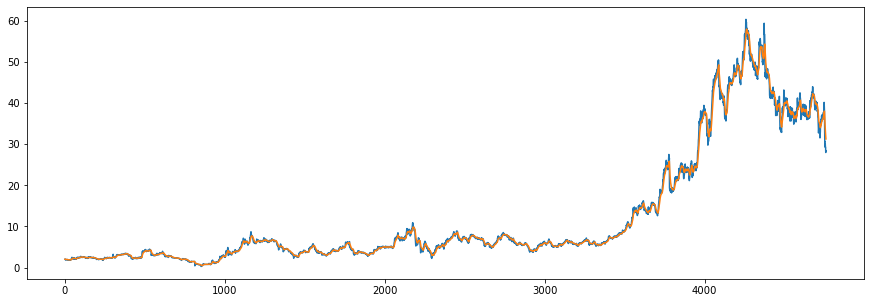

(4745, 15, 4)

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/HA_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['HA','JBLU','AAL']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'HawaiianModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'HawaiianModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 8.0084388185654, 1: 7.3140655105973025, 2: 0.36517556517556515}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/30 [>.............................] - ETA: 0s - loss: 0.3130 - accuracy: 0.5781 - mse: 0.3184 - weighted_accuracy: 0.3008 - weighted_mse: 0.5225WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 2s 51ms/step - loss: 0.2956 - accuracy: 0.5464 - mse: 0.4310 - weighted_accuracy: 0.3083 - weighted_mse: 0.5258 - val_loss: 0.2990 - val_accuracy: 0.0453 - val_mse: 0.3546 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3546
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2142 - accuracy: 0.3967 - mse: 0.7546 - weighted_accuracy: 0.4253 - weighted_mse: 0.7602 - val_loss: 0.2904 -

7/7 [==============================] - 0s 4ms/step - loss: 0.1879 - accuracy: 0.3744 - mse: 1.3538 - weighted_accuracy: 0.3744 - weighted_mse: 1.3538
Test loss: 0.18787410855293274
Test accuracy: 0.37442922592163086


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 107
actual holds but predicted sell: 22
actual predicted holds: 70
Percentage buys correct: 6.837606837606837%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 92.10526315789474%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 40.17094017094017%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 82.66666666666667%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pr

7/7 [==============================] - 0s 3ms/step - loss: 0.1802 - accuracy: 0.4404 - mse: 1.3512 - weighted_accuracy: 0.4404 - weighted_mse: 1.3512
Test loss: 0.180189311504364
Test accuracy: 0.4403669834136963


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 96
actual holds but predicted sell: 21
actual predicted holds: 86
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 16.0%
Percentage holds correct: 94.50549450549451%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 40.19607843137255%
Percentage high sells correct: 56.0%
Percentage mid holds correct: 84.44444444444444%


Capital: 100
Share price: $0.9408072327166555
Shares owned at the moment: 106
Cash capital at the moment: $0.00018802369761772297


Price increase from previously b

30/30 [==============================] - 0s 10ms/step - loss: 0.1445 - accuracy: 0.3498 - mse: 1.5027 - weighted_accuracy: 0.6934 - weighted_mse: 1.4100 - val_loss: 0.1858 - val_accuracy: 0.3867 - val_mse: 1.3634 - val_weighted_accuracy: 0.3867 - val_weighted_mse: 1.3634
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1443 - accuracy: 0.3899 - mse: 1.5016 - weighted_accuracy: 0.6881 - weighted_mse: 1.4190 - val_loss: 0.1823 - val_accuracy: 0.4015 - val_mse: 1.3492 - val_weighted_accuracy: 0.4015 - val_weighted_mse: 1.3492
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1426 - accuracy: 0.3952 - mse: 1.5388 - weighted_accuracy: 0.7096 - weighted_mse: 1.4501 - val_loss: 0.1765 - val_accuracy: 0.4468 - val_mse: 1.4081 - val_weighted_accuracy: 0.4468 - val_weighted_mse: 1.4081
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1409 - accuracy: 0.4210 - mse: 1.5313 - weighted_accuracy: 0.7076 - weighted_mse: 1.4542

7/7 [==============================] - 0s 3ms/step - loss: 0.1796 - accuracy: 0.4612 - mse: 1.7742 - weighted_accuracy: 0.4612 - weighted_mse: 1.7742
Test loss: 0.17961786687374115
Test accuracy: 0.4611872136592865


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 66
actual holds but predicted sell: 43
actual predicted holds: 90
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 90.9090909090909%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 46.478873239436616%
Percentage high sells correct: 47.916666666666664%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pri

7/7 [==============================] - 0s 4ms/step - loss: 0.1724 - accuracy: 0.4703 - mse: 1.7517 - weighted_accuracy: 0.4703 - weighted_mse: 1.7517
Test loss: 0.17241716384887695
Test accuracy: 0.47031962871551514


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 64
actual holds but predicted sell: 44
actual predicted holds: 89
Percentage buys correct: 12.162162162162161%
Percentage sells correct: 10.204081632653061%
Percentage holds correct: 92.70833333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.68493150684932%
Percentage high sells correct: 63.265306122448976%
Percentage mid holds correct: 86.45833333333333%


Capital: 100
Share price: $0.9807482772310598
Shares owned at the moment: 101
Cash capital at the moment: $0.6720211656620307


Pr

7/7 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.4749 - mse: 1.7724 - weighted_accuracy: 0.4749 - weighted_mse: 1.7724
Test loss: 0.17993146181106567
Test accuracy: 0.47488585114479065


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 71
actual holds but predicted sell: 37
actual predicted holds: 90
Percentage buys correct: 10.0%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 94.73684210526316%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 51.89873417721519%
Percentage high sells correct: 61.36363636363637%
Percentage mid holds correct: 85.26315789473684%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price increase from

Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1155 - accuracy: 0.5321 - mse: 1.9607 - weighted_accuracy: 0.7927 - weighted_mse: 1.9233 - val_loss: 0.1821 - val_accuracy: 0.4531 - val_mse: 2.0528 - val_weighted_accuracy: 0.4531 - val_weighted_mse: 2.0528
Epoch 11/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1159 - accuracy: 0.5590 - mse: 1.9819 - weighted_accuracy: 0.7989 - weighted_mse: 1.9549 - val_loss: 0.1864 - val_accuracy: 0.4700 - val_mse: 1.9981 - val_weighted_accuracy: 0.4700 - val_weighted_mse: 1.9981
Epoch 12/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1142 - accuracy: 0.5688 - mse: 1.9788 - weighted_accuracy: 0.8022 - weighted_mse: 1.9374 - val_loss: 0.1796 - val_accuracy: 0.4963 - val_mse: 2.0120 - val_weighted_accuracy: 0.4963 - val_weighted_mse: 2.0120
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1130 - accuracy: 0.5732 - mse: 1.9972 - weighted_accuracy: 0.8024 - weight

7/7 [==============================] - 0s 4ms/step - loss: 0.1879 - accuracy: 0.4817 - mse: 2.2026 - weighted_accuracy: 0.4817 - weighted_mse: 2.2026
Test loss: 0.18791614472866058
Test accuracy: 0.4816513657569885


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 56
actual holds but predicted sell: 45
actual predicted holds: 99
Percentage buys correct: 5.0%
Percentage sells correct: 6.122448979591836%
Percentage holds correct: 90.8256880733945%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 50.0%
Percentage high sells correct: 51.02040816326531%
Percentage mid holds correct: 80.55555555555556%


Capital: 100
Share price: $0.5919068635634861
Shares owned at the moment: 168
Cash capital at the moment: $0.28618595036799377


Price increase from previously bou

7/7 [==============================] - 0s 3ms/step - loss: 0.1817 - accuracy: 0.4725 - mse: 2.3865 - weighted_accuracy: 0.4725 - weighted_mse: 2.3865
Test loss: 0.181662917137146
Test accuracy: 0.4724770784378052


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 66
actual holds but predicted sell: 45
actual predicted holds: 92
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.0%
Percentage holds correct: 95.83333333333333%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 47.22222222222222%
Percentage high sells correct: 48.97959183673469%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -3.039572241

Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1064 - accuracy: 0.6080 - mse: 2.1509 - weighted_accuracy: 0.8301 - weighted_mse: 2.1357 - val_loss: 0.1801 - val_accuracy: 0.5047 - val_mse: 2.3242 - val_weighted_accuracy: 0.5047 - val_weighted_mse: 2.3242
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1048 - accuracy: 0.5938 - mse: 2.2018 - weighted_accuracy: 0.8308 - weighted_mse: 2.1771 - val_loss: 0.1670 - val_accuracy: 0.5701 - val_mse: 2.2143 - val_weighted_accuracy: 0.5701 - val_weighted_mse: 2.2143
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1060 - accuracy: 0.6180 - mse: 2.2076 - weighted_accuracy: 0.8296 - weighted_mse: 2.1934 - val_loss: 0.1649 - val_accuracy: 0.5690 - val_mse: 2.2458 - val_weighted_accuracy: 0.5690 - val_weighted_mse: 2.2458
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1034 - accuracy: 0.6257 - mse: 2.2423 - weighted_accuracy: 0.8481 - weighted_

7/7 [==============================] - 0s 4ms/step - loss: 0.1851 - accuracy: 0.5753 - mse: 2.7480 - weighted_accuracy: 0.5753 - weighted_mse: 2.7480
Test loss: 0.18511919677257538
Test accuracy: 0.5753424763679504


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 46
actual holds but predicted sell: 37
actual predicted holds: 116
Percentage buys correct: 8.0%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 92.06349206349206%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 48.97959183673469%
Percentage high sells correct: 46.51162790697674%
Percentage mid holds correct: 81.74603174603175%


Capital: 100
Share price: $0.7693948203617879
Shares owned at the moment: 129
Cash capital at the moment: $0.4751253608060182


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.1644 - accuracy: 0.5434 - mse: 2.7429 - weighted_accuracy: 0.5434 - weighted_mse: 2.7429
Test loss: 0.16435430943965912
Test accuracy: 0.543379008769989


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 46
actual holds but predicted sell: 46
actual predicted holds: 105
Percentage buys correct: 14.814814814814815%
Percentage sells correct: 11.538461538461538%
Percentage holds correct: 92.92035398230088%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.943396226415096%
Percentage high sells correct: 59.61538461538461%
Percentage mid holds correct: 87.61061946902655%


Capital: 100
Share price: $0.9453742245759735
Shares owned at the moment: 105
Cash capital at the moment: $0.46272961217647435


Pr

7/7 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.5525 - mse: 2.6333 - weighted_accuracy: 0.5525 - weighted_mse: 2.6333
Test loss: 0.16907842457294464
Test accuracy: 0.5525113940238953


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 54
actual holds but predicted sell: 38
actual predicted holds: 106
Percentage buys correct: 12.698412698412698%
Percentage sells correct: 15.217391304347826%
Percentage holds correct: 96.36363636363636%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 51.61290322580645%
Percentage high sells correct: 63.04347826086956%
Percentage mid holds correct: 84.54545454545455%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price

Epoch 11/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0844 - accuracy: 0.7300 - mse: 2.9946 - weighted_accuracy: 0.8864 - weighted_mse: 3.0540 - val_loss: 0.1866 - val_accuracy: 0.5627 - val_mse: 3.0725 - val_weighted_accuracy: 0.5627 - val_weighted_mse: 3.0725
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0817 - accuracy: 0.7205 - mse: 2.9991 - weighted_accuracy: 0.8866 - weighted_mse: 3.0307 - val_loss: 0.1556 - val_accuracy: 0.6565 - val_mse: 2.9732 - val_weighted_accuracy: 0.6565 - val_weighted_mse: 2.9732
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0800 - accuracy: 0.7358 - mse: 3.0430 - weighted_accuracy: 0.8962 - weighted_mse: 3.0921 - val_loss: 0.1617 - val_accuracy: 0.6270 - val_mse: 3.3531 - val_weighted_accuracy: 0.6270 - val_weighted_mse: 3.3531
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0802 - accuracy: 0.7350 - mse: 3.0748 - weighted_accuracy: 0.8838 - weighte

7/7 [==============================] - 0s 3ms/step - loss: 0.1760 - accuracy: 0.6101 - mse: 3.1511 - weighted_accuracy: 0.6101 - weighted_mse: 3.1511
Test loss: 0.1759909838438034
Test accuracy: 0.6100917458534241


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 33
actual holds but predicted sell: 36
actual predicted holds: 131
Percentage buys correct: 0.0%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 90.34482758620689%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 44.11764705882353%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.47210252301642774
Shares owned at the moment: 211
Cash capital at the moment: $0.11243015455346494


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.5688 - mse: 3.5033 - weighted_accuracy: 0.5688 - weighted_mse: 3.5033
Test loss: 0.16462299227714539
Test accuracy: 0.5688073635101318


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 46
actual holds but predicted sell: 41
actual predicted holds: 116
Percentage buys correct: 8.0%
Percentage sells correct: 8.88888888888889%
Percentage holds correct: 94.3089430894309%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 88.6178861788618%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -3.0395722419695903%
Share

Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0743 - accuracy: 0.7645 - mse: 3.3416 - weighted_accuracy: 0.9048 - weighted_mse: 3.3970 - val_loss: 0.1667 - val_accuracy: 0.6333 - val_mse: 3.6367 - val_weighted_accuracy: 0.6333 - val_weighted_mse: 3.6367
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0732 - accuracy: 0.7518 - mse: 3.3862 - weighted_accuracy: 0.9019 - weighted_mse: 3.4519 - val_loss: 0.1547 - val_accuracy: 0.6860 - val_mse: 3.8054 - val_weighted_accuracy: 0.6860 - val_weighted_mse: 3.8054
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0737 - accuracy: 0.7624 - mse: 3.4018 - weighted_accuracy: 0.8960 - weighted_mse: 3.4556 - val_loss: 0.1543 - val_accuracy: 0.6765 - val_mse: 3.6091 - val_weighted_accuracy: 0.6765 - val_weighted_mse: 3.6091
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0721 - accuracy: 0.7590 - mse: 3.4946 - weighted_accuracy: 0.9065 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.6712 - mse: 4.4328 - weighted_accuracy: 0.6712 - weighted_mse: 4.4328
Test loss: 0.18411226570606232
Test accuracy: 0.6712328791618347


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 27
actual holds but predicted sell: 30
actual predicted holds: 142
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 90.44585987261146%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 48.275862068965516%
Percentage high sells correct: 42.42424242424242%
Percentage mid holds correct: 81.41025641025641%


Capital: 100
Share price: $0.7693948203617879
Shares owned at the moment: 129
Cash capital at the moment: $0.4751253608060182


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.1531 - accuracy: 0.6055 - mse: 4.3201 - weighted_accuracy: 0.6055 - weighted_mse: 4.3201
Test loss: 0.15307699143886566
Test accuracy: 0.60550457239151


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 41
actual holds but predicted sell: 34
actual predicted holds: 128
Percentage buys correct: 2.380952380952381%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 92.7536231884058%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 48.648648648648646%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from pre




RUNNING EPOCHS 120 - 140



Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0613 - accuracy: 0.8114 - mse: 4.2199 - weighted_accuracy: 0.9275 - weighted_mse: 4.2587 - val_loss: 0.1693 - val_accuracy: 0.6786 - val_mse: 4.6622 - val_weighted_accuracy: 0.6786 - val_weighted_mse: 4.6622
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0601 - accuracy: 0.8101 - mse: 4.2666 - weighted_accuracy: 0.9250 - weighted_mse: 4.3193 - val_loss: 0.1518 - val_accuracy: 0.7482 - val_mse: 4.8717 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 4.8717
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0603 - accuracy: 0.8119 - mse: 4.3160 - weighted_accuracy: 0.9218 - weighted_mse: 4.3499 - val_loss: 0.1568 - val_accuracy: 0.7165 - val_mse: 4.6190 - val_weighted_accuracy: 0.7165 - val_weighted_mse: 4.6190
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0595 - accuracy: 0.8185 - mse: 4.4448 - weigh

7/7 [==============================] - 0s 3ms/step - loss: 0.1844 - accuracy: 0.7123 - mse: 5.6275 - weighted_accuracy: 0.7123 - weighted_mse: 5.6275
Test loss: 0.18442630767822266
Test accuracy: 0.7123287916183472


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 21
actual holds but predicted sell: 26
actual predicted holds: 152
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 90.47619047619048%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 44.827586206896555%
Percentage mid holds correct: 82.03592814371258%


Capital: 100
Share price: $0.5234211387001256
Shares owned at the moment: 190
Cash capital at the moment: $0.2764961020053107


Pri

7/7 [==============================] - 0s 4ms/step - loss: 0.1399 - accuracy: 0.7018 - mse: 5.2702 - weighted_accuracy: 0.7018 - weighted_mse: 5.2702
Test loss: 0.13991640508174896
Test accuracy: 0.7018348574638367


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 31
actual holds but predicted sell: 23
actual predicted holds: 149
Percentage buys correct: 3.125%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 93.71069182389937%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 40.625%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 86.79245283018868%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -42.24

30/30 [==============================] - 0s 16ms/step - loss: 0.0506 - accuracy: 0.8498 - mse: 5.3407 - weighted_accuracy: 0.9415 - weighted_mse: 5.3052 - val_loss: 0.1743 - val_accuracy: 0.7113 - val_mse: 5.8738 - val_weighted_accuracy: 0.7113 - val_weighted_mse: 5.8738
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0493 - accuracy: 0.8459 - mse: 5.3846 - weighted_accuracy: 0.9399 - weighted_mse: 5.3644 - val_loss: 0.1654 - val_accuracy: 0.7576 - val_mse: 6.3010 - val_weighted_accuracy: 0.7576 - val_weighted_mse: 6.3010
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0494 - accuracy: 0.8533 - mse: 5.4825 - weighted_accuracy: 0.9389 - weighted_mse: 5.4259 - val_loss: 0.1677 - val_accuracy: 0.7345 - val_mse: 5.8148 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 5.8148
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0489 - accuracy: 0.8570 - mse: 5.6055 - weighted_accuracy: 0.9459 - weighted_mse: 5.550

7/7 [==============================] - 0s 3ms/step - loss: 0.1964 - accuracy: 0.7580 - mse: 7.0440 - weighted_accuracy: 0.7580 - weighted_mse: 7.0440
Test loss: 0.19638395309448242
Test accuracy: 0.7579908967018127


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 18
actual predicted holds: 163
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 10.0%
Percentage holds correct: 90.55555555555556%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 47.36842105263158%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.68156424581005%


Capital: 100
Share price: $0.40970713961340044
Shares owned at the moment: 243
Cash capital at the moment: $0.1673782778970292


Price increase from previousl

7/7 [==============================] - 0s 3ms/step - loss: 0.1358 - accuracy: 0.7339 - mse: 6.3081 - weighted_accuracy: 0.7339 - weighted_mse: 6.3081
Test loss: 0.1358194798231125
Test accuracy: 0.7339449524879456


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 29
actual holds but predicted sell: 17
actual predicted holds: 157
Percentage buys correct: 3.3333333333333335%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 92.89940828402366%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 36.666666666666664%
Percentage high sells correct: 63.1578947368421%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from p

30/30 [==============================] - 0s 11ms/step - loss: 0.0407 - accuracy: 0.8862 - mse: 6.8665 - weighted_accuracy: 0.9546 - weighted_mse: 6.6309 - val_loss: 0.1773 - val_accuracy: 0.7619 - val_mse: 7.0576 - val_weighted_accuracy: 0.7619 - val_weighted_mse: 7.0576
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0406 - accuracy: 0.8822 - mse: 6.9705 - weighted_accuracy: 0.9552 - weighted_mse: 6.7393 - val_loss: 0.1841 - val_accuracy: 0.7661 - val_mse: 7.7772 - val_weighted_accuracy: 0.7661 - val_weighted_mse: 7.7772
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0405 - accuracy: 0.8878 - mse: 7.0257 - weighted_accuracy: 0.9590 - weighted_mse: 6.7716 - val_loss: 0.1953 - val_accuracy: 0.7229 - val_mse: 7.6012 - val_weighted_accuracy: 0.7229 - val_weighted_mse: 7.6012
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0398 - accuracy: 0.8830 - mse: 7.0411 - weighted_accuracy: 0.9573 - weighted_mse: 6.794

7/7 [==============================] - 0s 4ms/step - loss: 0.1836 - accuracy: 0.8165 - mse: 7.3129 - weighted_accuracy: 0.8165 - weighted_mse: 7.3129
Test loss: 0.18362262845039368
Test accuracy: 0.8165137767791748


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 6
actual holds but predicted sell: 18
actual predicted holds: 176
Percentage buys correct: 0.0%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 92.14659685863874%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 33.333333333333336%
Percentage high sells correct: 61.904761904761905%
Percentage mid holds correct: 83.15789473684211%


Capital: 100
Share price: $0.396308035393673
Shares owned at the moment: 251
Cash capital at the moment: $0.25313149475759644


Price increase from

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 17
actual holds but predicted sell: 18
actual predicted holds: 163
Percentage buys correct: 19.047619047619047%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 92.090395480226%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 70.0%
Percentage high sells correct: 61.904761904761905%
Percentage mid holds correct: 83.61581920903954%


Capital: 100
Share price: $0.5494307405243465
Shares owned at the moment: 181
Cash capital at the moment: $0.2795568139972886


Price increase from previously bought: -42.1149719480922%
Share price: $0.3189127431585882
Shares owned at the moment: 0
Cash capital at the moment: $57.84402450779456


Share price: $0.026332262812000677
Shares owned at the moment: 21

30/30 [==============================] - 0s 11ms/step - loss: 0.0317 - accuracy: 0.9104 - mse: 9.4681 - weighted_accuracy: 0.9655 - weighted_mse: 8.8883 - val_loss: 0.2264 - val_accuracy: 0.7756 - val_mse: 10.3924 - val_weighted_accuracy: 0.7756 - val_weighted_mse: 10.3924
Epoch 17/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0307 - accuracy: 0.9257 - mse: 9.5329 - weighted_accuracy: 0.9729 - weighted_mse: 8.8459 - val_loss: 0.2225 - val_accuracy: 0.7429 - val_mse: 9.8167 - val_weighted_accuracy: 0.7429 - val_weighted_mse: 9.8167
Epoch 18/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0320 - accuracy: 0.9123 - mse: 9.6233 - weighted_accuracy: 0.9661 - weighted_mse: 8.9733 - val_loss: 0.2276 - val_accuracy: 0.7587 - val_mse: 10.6908 - val_weighted_accuracy: 0.7587 - val_weighted_mse: 10.6908
Epoch 19/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0311 - accuracy: 0.9189 - mse: 9.7881 - weighted_accuracy: 0.9663 - weighted_mse

7/7 [==============================] - 0s 5ms/step - loss: 0.1761 - accuracy: 0.7763 - mse: 10.2394 - weighted_accuracy: 0.7763 - weighted_mse: 10.2394
Test loss: 0.1761077642440796
Test accuracy: 0.77625572681427


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 8
actual holds but predicted sell: 22
actual predicted holds: 167
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 89.78494623655914%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 41.666666666666664%
Percentage mid holds correct: 84.32432432432432%


Capital: 100
Share price: $0.6025170038678631
Shares owned at the moment: 165
Cash capital at the moment: $0.3113022712975493


Price

In [16]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0    406.242589
1    -57.702348
2    -85.622825
Name: Profit gained, dtype: float64

In [17]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


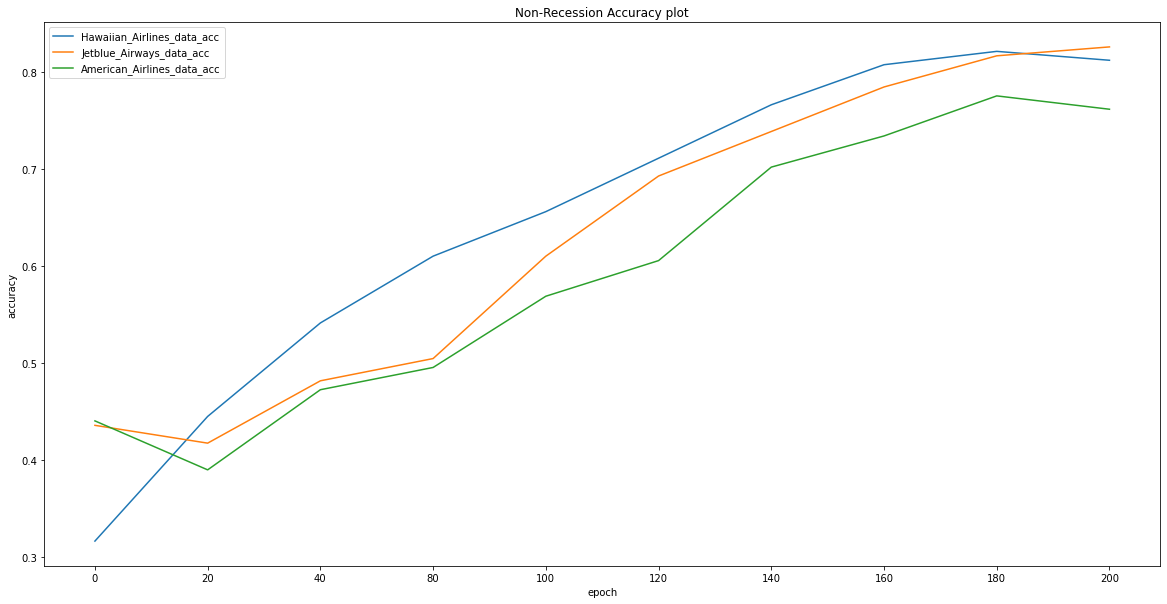

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

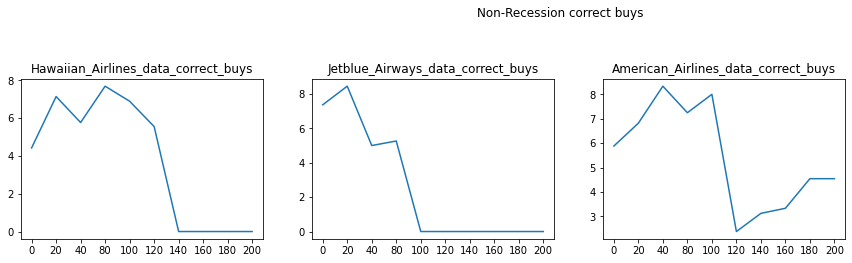

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

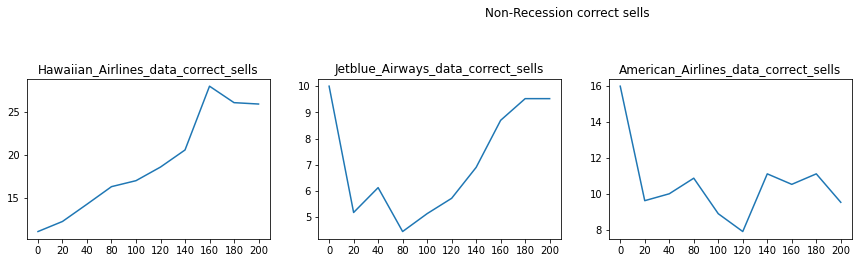

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

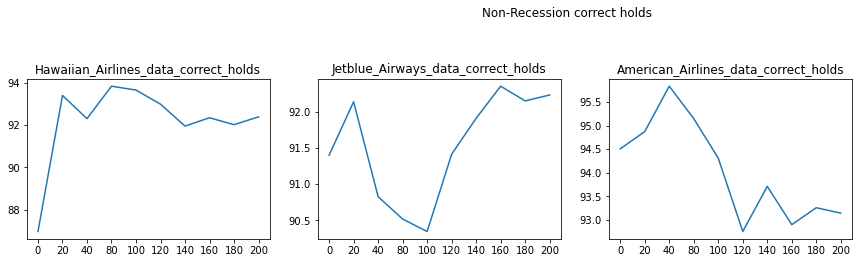

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

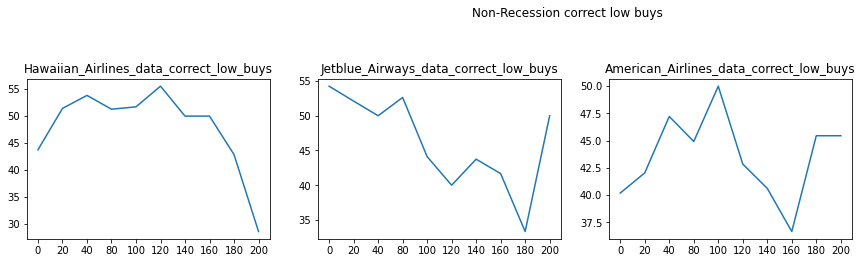

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

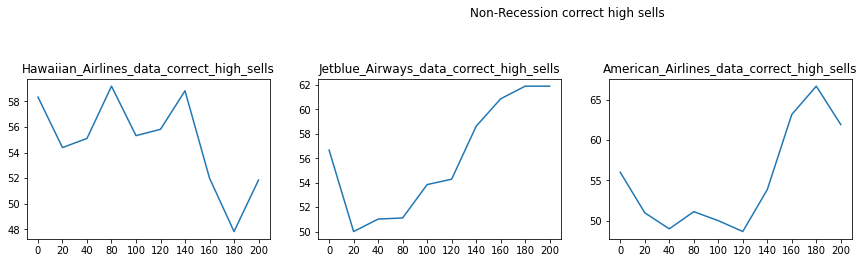

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

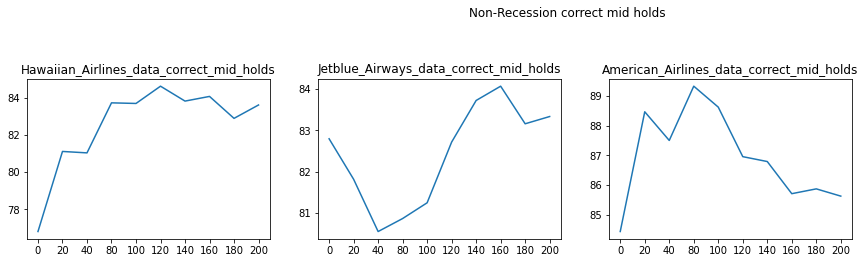

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

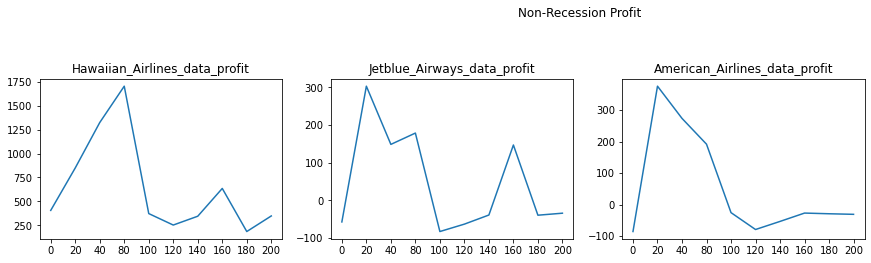

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

In [26]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


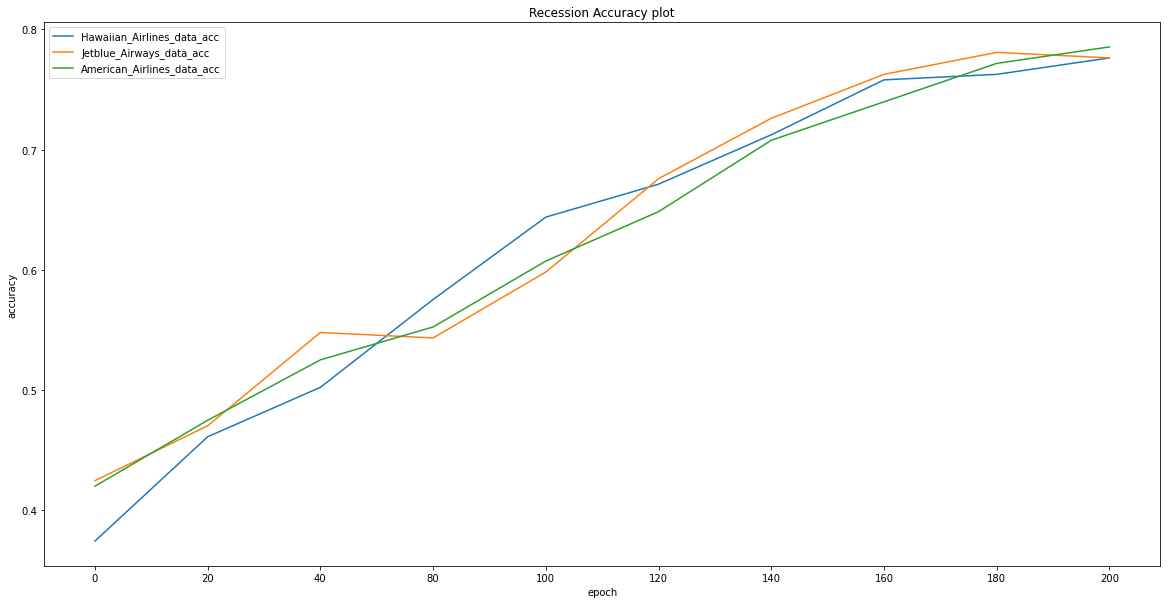

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

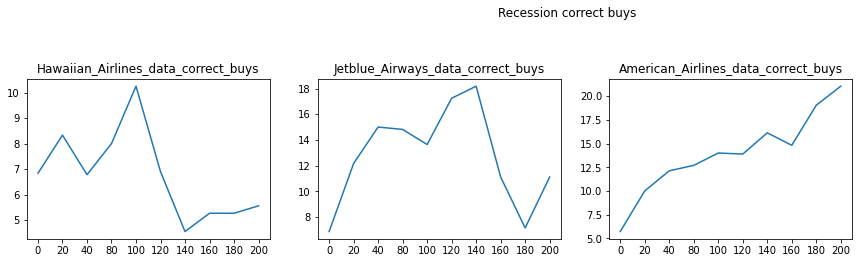

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

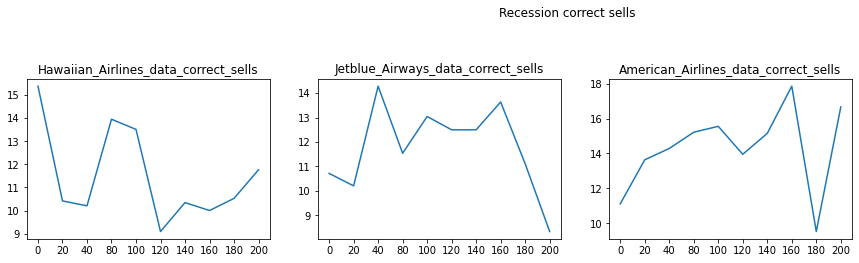

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

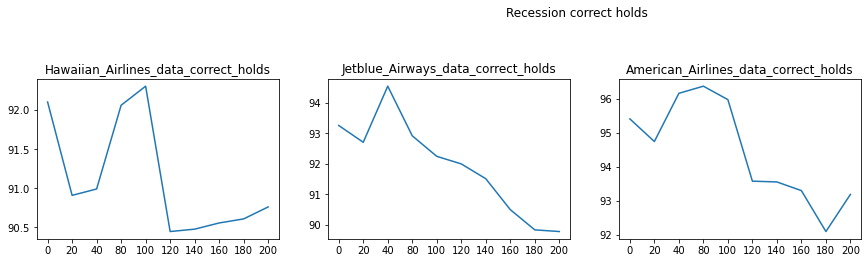

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

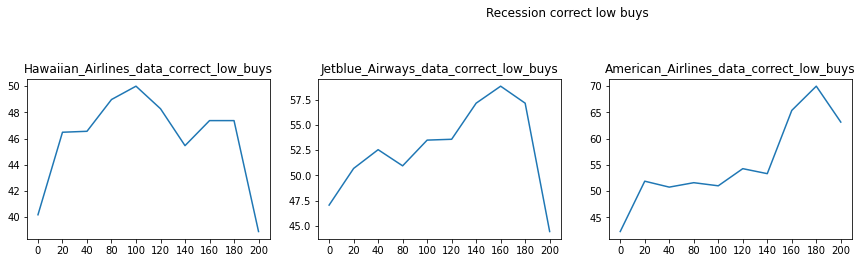

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

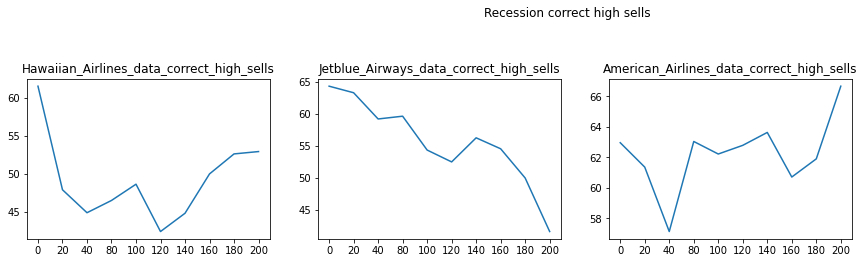

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

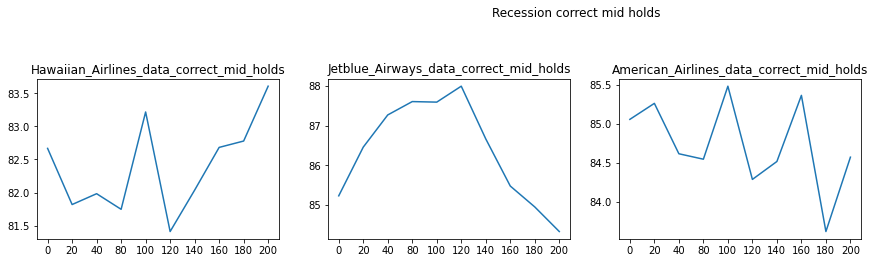

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

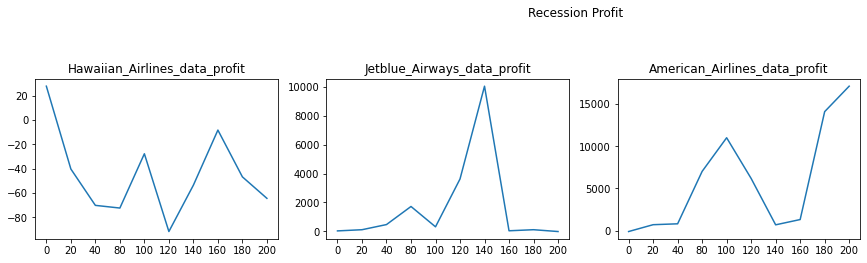

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

## Train JetBlue Airways Corporation  Stock Data

In [35]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-05-02    14.761481  13.724947  -5.141986  58104336.0     2.0
2002-05-03    14.562963  13.853872 -13.413429  57315261.0     2.0
2002-05-06    15.419259  14.094701  -0.086583  58757399.0     0.0
2002-05-07    16.148148  14.410616  -4.436861  61163774.0     2.0
2002-05-08    14.696296  14.454567 -37.883964  57784724.0     2.0


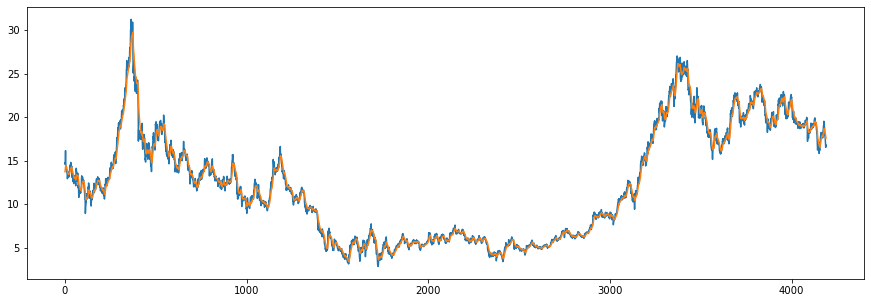

(4175, 15, 4)

In [36]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/JBLU_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [37]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [38]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [39]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [41]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['HA','JBLU','AAL']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'JetblueModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'JetblueModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.276688453159041, 1: 7.6255707762557075, 2: 0.3661076400306917}



RUNNING EPOCHS 0 - 20



Epoch 1/20
27/27 [==============================] - 4s 133ms/step - loss: 0.2954 - accuracy: 0.5240 - mse: 0.4366 - weighted_accuracy: 0.3266 - weighted_mse: 0.5115 - val_loss: 0.3001 - val_accuracy: 0.0431 - val_mse: 0.3519 - val_weighted_accuracy: 0.0431 - val_weighted_mse: 0.3519
Epoch 2/20
27/27 [==============================] - 0s 11ms/step - loss: 0.2146 - accuracy: 0.3719 - mse: 0.7316 - weighted_accuracy: 0.4459 - weighted_mse: 0.7193 - val_loss: 0.2934 - val_accuracy: 0.0443 - val_mse: 0.3776 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.3776
Epoch 3/20
27/27 [==============================] - 0s 10ms/step - loss: 0.1913 - accuracy: 0.3216 - mse: 0.9504 - weighted_accuracy: 0.4956 - weighted_mse: 0.9196 - val_loss: 0.2855 - val_accuracy: 0.0443 - val_mse: 0.4121 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.4121
Epoch 4/20
27/27 [==============================] - 0

7/7 [==============================] - 0s 3ms/step - loss: 0.1872 - accuracy: 0.3699 - mse: 1.4075 - weighted_accuracy: 0.3699 - weighted_mse: 1.4075
Test loss: 0.18719810247421265
Test accuracy: 0.36986300349235535


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 55
actual holds but predicted sell: 73
actual predicted holds: 71
Percentage buys correct: 6.779661016949152%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 89.87341772151899%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 37.28813559322034%
Percentage high sells correct: 49.382716049382715%
Percentage mid holds correct: 85.8974358974359%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.1885 - accuracy: 0.3257 - mse: 1.3302 - weighted_accuracy: 0.3257 - weighted_mse: 1.3302
Test loss: 0.188509002327919
Test accuracy: 0.32568806409835815


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 79
actual holds but predicted sell: 61
actual predicted holds: 63
Percentage buys correct: 7.0588235294117645%
Percentage sells correct: 3.1746031746031744%
Percentage holds correct: 90.0%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 40.0%
Percentage high sells correct: 45.16129032258065%
Percentage mid holds correct: 81.42857142857143%


Capital: 100
Share price: $0.9193905659452468
Shares owned at the moment: 108
Cash capital at the moment: $0.4327598798276


Price increase from previously bough




RUNNING EPOCHS 20 - 40



Epoch 1/20
27/27 [==============================] - 1s 54ms/step - loss: 0.1431 - accuracy: 0.3377 - mse: 1.5502 - weighted_accuracy: 0.6771 - weighted_mse: 1.4588 - val_loss: 0.1865 - val_accuracy: 0.3760 - val_mse: 1.3360 - val_weighted_accuracy: 0.3760 - val_weighted_mse: 1.3360
Epoch 2/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1445 - accuracy: 0.3527 - mse: 1.5407 - weighted_accuracy: 0.6889 - weighted_mse: 1.4646 - val_loss: 0.1840 - val_accuracy: 0.3928 - val_mse: 1.3111 - val_weighted_accuracy: 0.3928 - val_weighted_mse: 1.3111
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1435 - accuracy: 0.3401 - mse: 1.5203 - weighted_accuracy: 0.6783 - weighted_mse: 1.4413 - val_loss: 0.1885 - val_accuracy: 0.3341 - val_mse: 1.3839 - val_weighted_accuracy: 0.3341 - val_weighted_mse: 1.3839
Epoch 4/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1404 - accuracy: 0.3467 - mse: 1.5694 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1557 - accuracy: 0.5982 - mse: 1.8112 - weighted_accuracy: 0.5982 - weighted_mse: 1.8112
Test loss: 0.15574586391448975
Test accuracy: 0.5981734991073608


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 43
actual holds but predicted sell: 33
actual predicted holds: 123
Percentage buys correct: 10.416666666666666%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 91.7910447761194%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 47.916666666666664%
Percentage high sells correct: 48.648648648648646%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pr

7/7 [==============================] - 0s 3ms/step - loss: 0.1613 - accuracy: 0.5708 - mse: 1.7908 - weighted_accuracy: 0.5708 - weighted_mse: 1.7908
Test loss: 0.1612713485956192
Test accuracy: 0.5707762837409973


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 35
actual holds but predicted sell: 49
actual predicted holds: 113
Percentage buys correct: 12.5%
Percentage sells correct: 12.280701754385966%
Percentage holds correct: 92.62295081967213%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 55.0%
Percentage high sells correct: 56.14035087719298%
Percentage mid holds correct: 85.9504132231405%


Capital: 100
Share price: $0.7848299580775777
Shares owned at the moment: 127
Cash capital at the moment: $0.052493461289031984


Price increase from previously

7/7 [==============================] - 0s 3ms/step - loss: 0.1704 - accuracy: 0.5023 - mse: 1.7604 - weighted_accuracy: 0.5023 - weighted_mse: 1.7604
Test loss: 0.1704261153936386
Test accuracy: 0.5022830963134766


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 47
actual holds but predicted sell: 52
actual predicted holds: 99
Percentage buys correct: 12.5%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 92.5233644859813%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 58.92857142857143%
Percentage high sells correct: 47.27272727272727%
Percentage mid holds correct: 83.17757009345794%


Capital: 100
Share price: $0.6670229259663452
Shares owned at the moment: 149
Cash capital at the moment: $0.34027138709986104


Price increase from p

27/27 [==============================] - 0s 8ms/step - loss: 0.1158 - accuracy: 0.5383 - mse: 2.0130 - weighted_accuracy: 0.7914 - weighted_mse: 2.0003 - val_loss: 0.1986 - val_accuracy: 0.4168 - val_mse: 1.9810 - val_weighted_accuracy: 0.4168 - val_weighted_mse: 1.9810
Epoch 13/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1152 - accuracy: 0.5374 - mse: 2.0608 - weighted_accuracy: 0.7881 - weighted_mse: 2.0480 - val_loss: 0.1841 - val_accuracy: 0.4635 - val_mse: 2.0292 - val_weighted_accuracy: 0.4635 - val_weighted_mse: 2.0292
Epoch 14/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1138 - accuracy: 0.5386 - mse: 2.1037 - weighted_accuracy: 0.7826 - weighted_mse: 2.1137 - val_loss: 0.1905 - val_accuracy: 0.4371 - val_mse: 2.1567 - val_weighted_accuracy: 0.4371 - val_weighted_mse: 2.1567
Epoch 15/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1154 - accuracy: 0.5216 - mse: 2.1129 - weighted_accuracy: 0.7779 - weighted_mse: 2.0959

7/7 [==============================] - 0s 3ms/step - loss: 0.1895 - accuracy: 0.4495 - mse: 2.2875 - weighted_accuracy: 0.4495 - weighted_mse: 2.2875
Test loss: 0.18948371708393097
Test accuracy: 0.44954127073287964


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 59
actual holds but predicted sell: 50
actual predicted holds: 91
Percentage buys correct: 6.349206349206349%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 90.0990099009901%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 47.61904761904762%
Percentage high sells correct: 60.37735849056604%
Percentage mid holds correct: 82.17821782178218%


Capital: 100
Share price: $0.4549876838446172
Shares owned at the moment: 219
Cash capital at the moment: $0.08368090543341111


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.4954 - mse: 2.1867 - weighted_accuracy: 0.4954 - weighted_mse: 2.1867
Test loss: 0.17747408151626587
Test accuracy: 0.4954128563404083


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 47
actual holds but predicted sell: 57
actual predicted holds: 99
Percentage buys correct: 9.433962264150944%
Percentage sells correct: 6.557377049180328%
Percentage holds correct: 95.1923076923077%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 50.943396226415096%
Percentage high sells correct: 46.666666666666664%
Percentage mid holds correct: 89.42307692307692%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from pr




RUNNING EPOCHS 60 - 80



Epoch 1/20
27/27 [==============================] - 0s 14ms/step - loss: 0.1087 - accuracy: 0.5656 - mse: 2.2139 - weighted_accuracy: 0.8201 - weighted_mse: 2.2303 - val_loss: 0.1803 - val_accuracy: 0.5006 - val_mse: 2.2916 - val_weighted_accuracy: 0.5006 - val_weighted_mse: 2.2916
Epoch 2/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1121 - accuracy: 0.5572 - mse: 2.2045 - weighted_accuracy: 0.7934 - weighted_mse: 2.2194 - val_loss: 0.1907 - val_accuracy: 0.4539 - val_mse: 2.1136 - val_weighted_accuracy: 0.4539 - val_weighted_mse: 2.1136
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1107 - accuracy: 0.5593 - mse: 2.1862 - weighted_accuracy: 0.7983 - weighted_mse: 2.2133 - val_loss: 0.1881 - val_accuracy: 0.4539 - val_mse: 2.2785 - val_weighted_accuracy: 0.4539 - val_weighted_mse: 2.2785
Epoch 4/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1070 - accuracy: 0.5760 - mse: 2.2250 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1303 - accuracy: 0.6986 - mse: 2.5802 - weighted_accuracy: 0.6986 - weighted_mse: 2.5802
Test loss: 0.13029460608959198
Test accuracy: 0.698630154132843


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 29
actual holds but predicted sell: 23
actual predicted holds: 147
Percentage buys correct: 9.375%
Percentage sells correct: 11.538461538461538%
Percentage holds correct: 91.30434782608695%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 40.625%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 82.5%


Capital: 100
Share price: $0.8962860009132746
Shares owned at the moment: 111
Cash capital at the moment: $0.23866259684774604


Price increase from previously bought: -

7/7 [==============================] - 0s 3ms/step - loss: 0.1644 - accuracy: 0.5596 - mse: 2.6057 - weighted_accuracy: 0.5596 - weighted_mse: 2.6057
Test loss: 0.16435174643993378
Test accuracy: 0.5596330165863037


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 39
actual holds but predicted sell: 49
actual predicted holds: 115
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 7.547169811320755%
Percentage holds correct: 94.26229508196721%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 51.16279069767442%
Percentage high sells correct: 48.07692307692308%
Percentage mid holds correct: 89.34426229508196%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from pr

27/27 [==============================] - 0s 15ms/step - loss: 0.0934 - accuracy: 0.6623 - mse: 2.6434 - weighted_accuracy: 0.8637 - weighted_mse: 2.7314 - val_loss: 0.1722 - val_accuracy: 0.5940 - val_mse: 2.8446 - val_weighted_accuracy: 0.5940 - val_weighted_mse: 2.8446
Epoch 2/20
27/27 [==============================] - 0s 10ms/step - loss: 0.0971 - accuracy: 0.6521 - mse: 2.6236 - weighted_accuracy: 0.8452 - weighted_mse: 2.6988 - val_loss: 0.1801 - val_accuracy: 0.5461 - val_mse: 2.4841 - val_weighted_accuracy: 0.5461 - val_weighted_mse: 2.4841
Epoch 3/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0956 - accuracy: 0.6626 - mse: 2.6027 - weighted_accuracy: 0.8487 - weighted_mse: 2.6932 - val_loss: 0.1874 - val_accuracy: 0.5114 - val_mse: 2.8108 - val_weighted_accuracy: 0.5114 - val_weighted_mse: 2.8108
Epoch 4/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0925 - accuracy: 0.6608 - mse: 2.6975 - weighted_accuracy: 0.8546 - weighted_mse: 2.7802 

7/7 [==============================] - 0s 3ms/step - loss: 0.1279 - accuracy: 0.7534 - mse: 3.1320 - weighted_accuracy: 0.7534 - weighted_mse: 3.1320
Test loss: 0.12791888415813446
Test accuracy: 0.7534246444702148


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 25
actual holds but predicted sell: 15
actual predicted holds: 159
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 91.90751445086705%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 39.285714285714285%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 83.72093023255815%


Capital: 100
Share price: $0.8962860009132746
Shares owned at the moment: 111
Cash capital at the moment: $0.23866259684774604


P

7/7 [==============================] - 0s 3ms/step - loss: 0.1635 - accuracy: 0.6330 - mse: 3.0297 - weighted_accuracy: 0.6330 - weighted_mse: 3.0297
Test loss: 0.16351377964019775
Test accuracy: 0.6330274939537048


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 36
actual holds but predicted sell: 36
actual predicted holds: 131
Percentage buys correct: 7.5%
Percentage sells correct: 10.0%
Percentage holds correct: 94.92753623188406%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 52.5%
Percentage high sells correct: 52.5%
Percentage mid holds correct: 88.32116788321167%


Capital: 100
Share price: $0.9177430816973706
Shares owned at the moment: 108
Cash capital at the moment: $0.6111774814198441


Price increase from previously bought: -22.472516658853735%


27/27 [==============================] - 0s 9ms/step - loss: 0.0815 - accuracy: 0.7317 - mse: 3.2129 - weighted_accuracy: 0.8913 - weighted_mse: 3.3554 - val_loss: 0.1819 - val_accuracy: 0.6060 - val_mse: 3.1491 - val_weighted_accuracy: 0.6060 - val_weighted_mse: 3.1491
Epoch 3/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0805 - accuracy: 0.7323 - mse: 3.2396 - weighted_accuracy: 0.8934 - weighted_mse: 3.3886 - val_loss: 0.1850 - val_accuracy: 0.5737 - val_mse: 3.3729 - val_weighted_accuracy: 0.5737 - val_weighted_mse: 3.3729
Epoch 4/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0788 - accuracy: 0.7362 - mse: 3.3438 - weighted_accuracy: 0.8928 - weighted_mse: 3.4763 - val_loss: 0.1973 - val_accuracy: 0.5389 - val_mse: 3.3657 - val_weighted_accuracy: 0.5389 - val_weighted_mse: 3.3657
Epoch 5/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0788 - accuracy: 0.7371 - mse: 3.3101 - weighted_accuracy: 0.8952 - weighted_mse: 3.4288 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1145 - accuracy: 0.8082 - mse: 4.0774 - weighted_accuracy: 0.8082 - weighted_mse: 4.0774
Test loss: 0.11454594135284424
Test accuracy: 0.8082191944122314


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 15
actual holds but predicted sell: 11
actual predicted holds: 173
Percentage buys correct: 6.25%
Percentage sells correct: 21.428571428571427%
Percentage holds correct: 91.53439153439153%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 31.25%
Percentage high sells correct: 64.28571428571429%
Percentage mid holds correct: 84.04255319148936%


Capital: 100
Share price: $0.8264958469556171
Shares owned at the moment: 120
Cash capital at the moment: $0.5477547358305941


Price increase from previousl

7/7 [==============================] - 0s 3ms/step - loss: 0.1416 - accuracy: 0.6789 - mse: 3.7253 - weighted_accuracy: 0.6789 - weighted_mse: 3.7253
Test loss: 0.14162488281726837
Test accuracy: 0.6788991093635559


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 30
actual holds but predicted sell: 29
actual predicted holds: 144
Percentage buys correct: 3.125%
Percentage sells correct: 9.375%
Percentage holds correct: 93.50649350649351%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 46.875%
Percentage high sells correct: 53.125%
Percentage mid holds correct: 86.9281045751634%


Capital: 100
Share price: $0.9177430816973706
Shares owned at the moment: 108
Cash capital at the moment: $0.6111774814198441


Price increase from previously bought: -12.89503786725

27/27 [==============================] - 0s 8ms/step - loss: 0.0668 - accuracy: 0.7883 - mse: 4.0613 - weighted_accuracy: 0.9116 - weighted_mse: 4.2263 - val_loss: 0.1890 - val_accuracy: 0.6371 - val_mse: 4.1169 - val_weighted_accuracy: 0.6371 - val_weighted_mse: 4.1169
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0651 - accuracy: 0.7913 - mse: 4.1772 - weighted_accuracy: 0.9128 - weighted_mse: 4.3464 - val_loss: 0.2063 - val_accuracy: 0.5868 - val_mse: 4.0421 - val_weighted_accuracy: 0.5868 - val_weighted_mse: 4.0421
Epoch 5/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.7886 - mse: 4.1352 - weighted_accuracy: 0.9140 - weighted_mse: 4.2789 - val_loss: 0.1743 - val_accuracy: 0.6551 - val_mse: 4.1498 - val_weighted_accuracy: 0.6551 - val_weighted_mse: 4.1498
Epoch 6/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0623 - accuracy: 0.8108 - mse: 4.1840 - weighted_accuracy: 0.9287 - weighted_mse: 4.3557 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1260 - accuracy: 0.8037 - mse: 5.0405 - weighted_accuracy: 0.8037 - weighted_mse: 5.0405
Test loss: 0.12602825462818146
Test accuracy: 0.8036529421806335


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 16
actual holds but predicted sell: 12
actual predicted holds: 171
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 20.0%
Percentage holds correct: 91.93548387096774%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 27.77777777777778%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 84.32432432432432%


Capital: 100
Share price: $0.5161005133597479
Shares owned at the moment: 193
Cash capital at the moment: $0.11868057410295307


Price increase from previously



Share price: $0.3297279251390281
Shares owned at the moment: 210
Cash capital at the moment: $0.26404107243155295




Capital at the end of test period: $109.06402445074461
profit gained: 9.064024450744611%


Capital at the end of test period if Buy and Hold: $55.155916676290765
profit gained: -44.844083323709235%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.803653     11.111111           20.0      91.935484   
1       0.748858      0.000000           10.0      89.010989   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         27.777778                60.0          84.324324     -70.302096   
1         58.823529                75.0          83.977901       9.064024   

   buy_n_hold profit  
0         -51.275942  
1         -44.844083  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1393 - accuracy: 0.7110 - mse: 4.4437 - weighted_accuracy: 0.7110 - weighted_mse: 4.4437
Test loss: 0.1392591

2         -63.196503  



RUNNING EPOCHS 140 - 160



Epoch 1/20
27/27 [==============================] - 0s 15ms/step - loss: 0.0535 - accuracy: 0.8326 - mse: 4.9110 - weighted_accuracy: 0.9345 - weighted_mse: 5.0959 - val_loss: 0.1704 - val_accuracy: 0.7174 - val_mse: 5.2341 - val_weighted_accuracy: 0.7174 - val_weighted_mse: 5.2341
Epoch 2/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0546 - accuracy: 0.8431 - mse: 5.0211 - weighted_accuracy: 0.9383 - weighted_mse: 5.1520 - val_loss: 0.1851 - val_accuracy: 0.7066 - val_mse: 4.9336 - val_weighted_accuracy: 0.7066 - val_weighted_mse: 4.9336
Epoch 3/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0542 - accuracy: 0.8422 - mse: 5.0428 - weighted_accuracy: 0.9357 - weighted_mse: 5.1822 - val_loss: 0.1880 - val_accuracy: 0.6754 - val_mse: 4.9691 - val_weighted_accuracy: 0.6754 - val_weighted_mse: 4.9691
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.8338 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1325 - accuracy: 0.8219 - mse: 6.3744 - weighted_accuracy: 0.8219 - weighted_mse: 6.3744
Test loss: 0.1325371265411377
Test accuracy: 0.8219178318977356


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 12
actual holds but predicted sell: 11
actual predicted holds: 176
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 21.428571428571427%
Percentage holds correct: 91.66666666666667%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 23.076923076923077%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 84.29319371727749%


Capital: 100
Share price: $0.5161005133597479
Shares owned at the moment: 193
Cash capital at the moment: $0.11868057410295307


P

7/7 [==============================] - 0s 3ms/step - loss: 0.1368 - accuracy: 0.7431 - mse: 5.4362 - weighted_accuracy: 0.7431 - weighted_mse: 5.4362
Test loss: 0.1367586851119995
Test accuracy: 0.7431192398071289


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 23
actual holds but predicted sell: 21
actual predicted holds: 159
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 93.52941176470588%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 57.69230769230769%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 86.98224852071006%


Capital: 100
Share price: $0.9177430816973706
Shares owned at the moment: 108
Cash capital at the moment: $0.6111774814198441


Price i

27/27 [==============================] - 0s 9ms/step - loss: 0.0459 - accuracy: 0.8683 - mse: 6.2201 - weighted_accuracy: 0.9475 - weighted_mse: 6.2516 - val_loss: 0.1933 - val_accuracy: 0.7293 - val_mse: 6.0816 - val_weighted_accuracy: 0.7293 - val_weighted_mse: 6.0816
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0448 - accuracy: 0.8751 - mse: 6.2517 - weighted_accuracy: 0.9478 - weighted_mse: 6.3035 - val_loss: 0.1879 - val_accuracy: 0.7138 - val_mse: 6.1896 - val_weighted_accuracy: 0.7138 - val_weighted_mse: 6.1896
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0437 - accuracy: 0.8710 - mse: 6.3693 - weighted_accuracy: 0.9462 - weighted_mse: 6.4225 - val_loss: 0.2138 - val_accuracy: 0.6671 - val_mse: 6.0899 - val_weighted_accuracy: 0.6671 - val_weighted_mse: 6.0899
Epoch 5/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0445 - accuracy: 0.8713 - mse: 6.3871 - weighted_accuracy: 0.9529 - weighted_mse: 6.3645 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1445 - accuracy: 0.8493 - mse: 8.0629 - weighted_accuracy: 0.8493 - weighted_mse: 8.0629
Test loss: 0.14445720613002777
Test accuracy: 0.8493150472640991


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 5
actual holds but predicted sell: 12
actual predicted holds: 182
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 20.0%
Percentage holds correct: 91.91919191919192%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 33.333333333333336%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 84.77157360406092%


Capital: 100
Share price: $0.5161005133597479
Shares owned at the moment: 193
Cash capital at the moment: $0.11868057410295307


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.1293 - accuracy: 0.8028 - mse: 6.7136 - weighted_accuracy: 0.8028 - weighted_mse: 6.7136
Test loss: 0.12933702766895294
Test accuracy: 0.8027523159980774


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 14
actual holds but predicted sell: 16
actual predicted holds: 173
Percentage buys correct: 6.25%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 93.51351351351352%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 68.75%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 86.41304347826087%


Capital: 100
Share price: $0.9177430816973706
Shares owned at the moment: 108
Cash capital at the moment: $0.6111774814198441


Price increase from previously b

27/27 [==============================] - 0s 9ms/step - loss: 0.0362 - accuracy: 0.9006 - mse: 7.6813 - weighted_accuracy: 0.9614 - weighted_mse: 7.5460 - val_loss: 0.2223 - val_accuracy: 0.6838 - val_mse: 7.0390 - val_weighted_accuracy: 0.6838 - val_weighted_mse: 7.0390
Epoch 5/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0365 - accuracy: 0.8940 - mse: 7.7101 - weighted_accuracy: 0.9612 - weighted_mse: 7.5013 - val_loss: 0.1908 - val_accuracy: 0.7808 - val_mse: 8.1499 - val_weighted_accuracy: 0.7808 - val_weighted_mse: 8.1499
Epoch 6/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0341 - accuracy: 0.9093 - mse: 7.8316 - weighted_accuracy: 0.9626 - weighted_mse: 7.6475 - val_loss: 0.1938 - val_accuracy: 0.7617 - val_mse: 8.0363 - val_weighted_accuracy: 0.7617 - val_weighted_mse: 8.0363
Epoch 7/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0345 - accuracy: 0.9117 - mse: 7.9619 - weighted_accuracy: 0.9677 - weighted_mse: 7.7044 - 

7/7 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.7385 - mse: 9.0395 - weighted_accuracy: 0.7385 - weighted_mse: 9.0395
Test loss: 0.21759819984436035
Test accuracy: 0.7385321259498596


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 21
actual holds but predicted sell: 21
actual predicted holds: 158
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 91.32947976878613%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 43.47826086956522%
Percentage high sells correct: 72.72727272727273%
Percentage mid holds correct: 82.55813953488372%


Capital: 100
Share price: $0.1371394714825731
Shares owned at the moment: 727
Cash capital at the moment: $0.025428143807815218


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.1920 - accuracy: 0.8174 - mse: 9.9860 - weighted_accuracy: 0.8174 - weighted_mse: 9.9860
Test loss: 0.19202111661434174
Test accuracy: 0.8173515796661377


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 13
actual holds but predicted sell: 11
actual predicted holds: 174
Percentage buys correct: 23.529411764705884%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 91.57894736842105%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.01058201058201%


Capital: 100
Share price: $0.4528371914125876
Shares owned at the moment: 220
Cash capital at the moment: $0.10185138842611252


Price increase fr

In [42]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


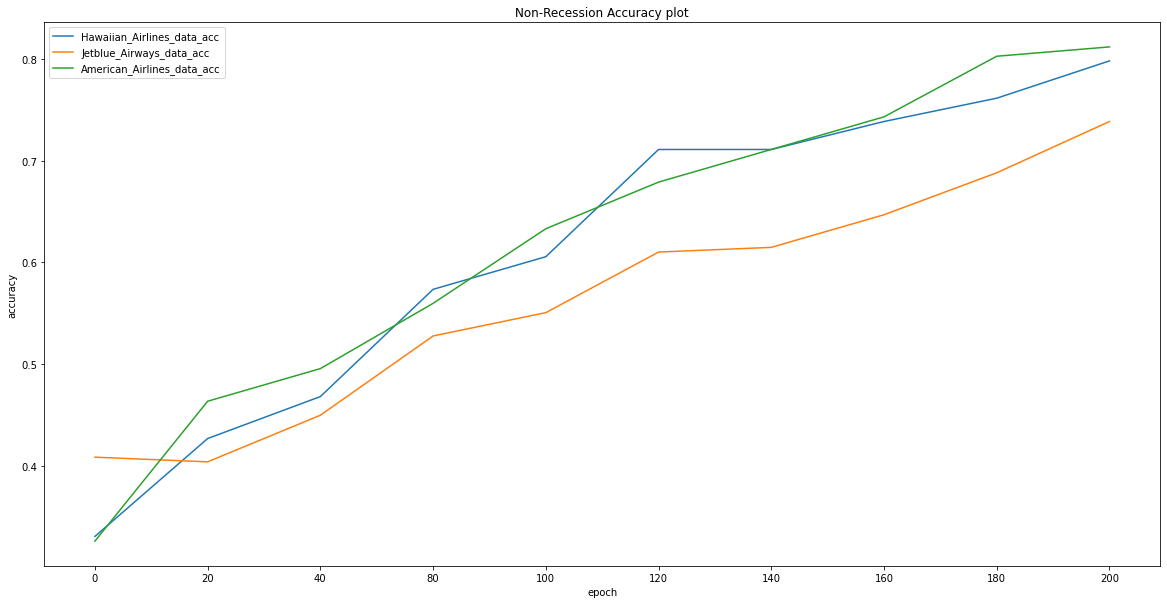

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

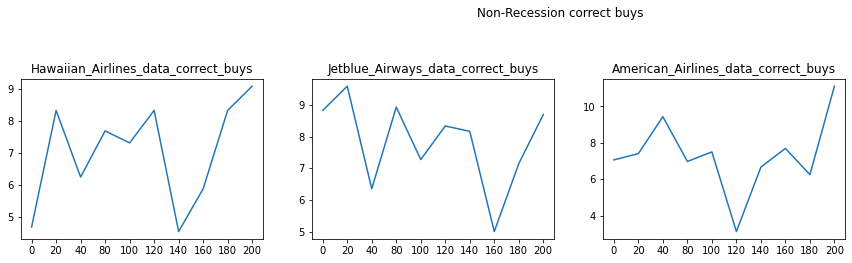

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

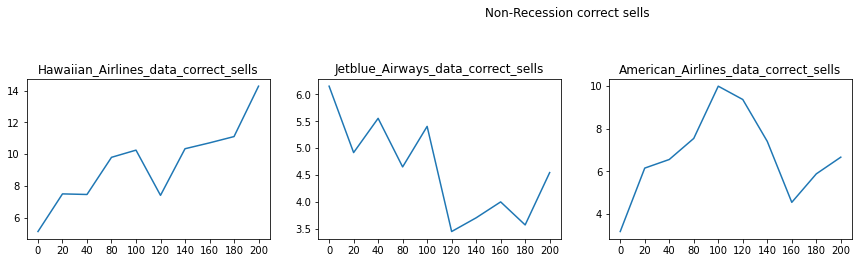

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

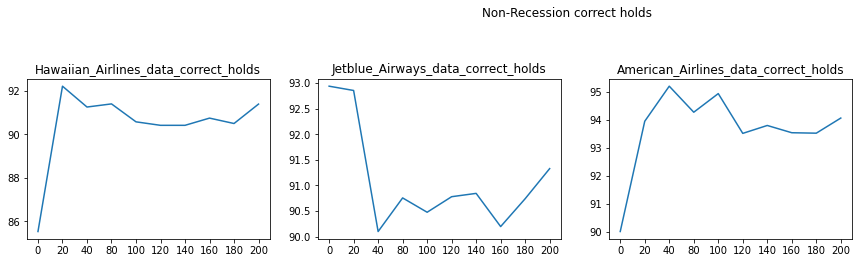

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

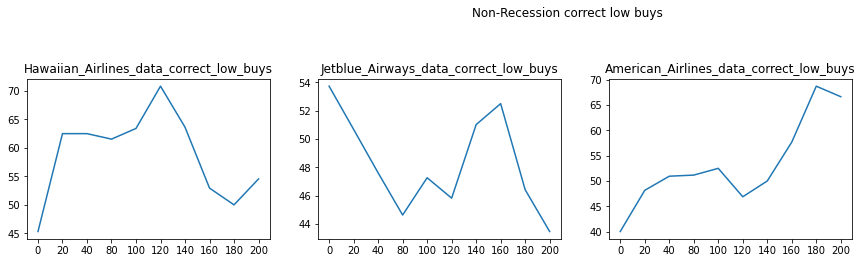

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

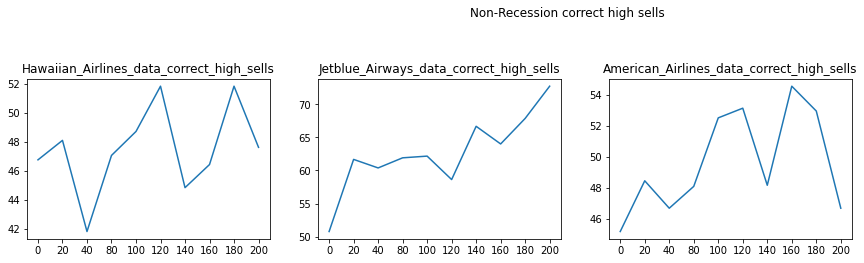

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

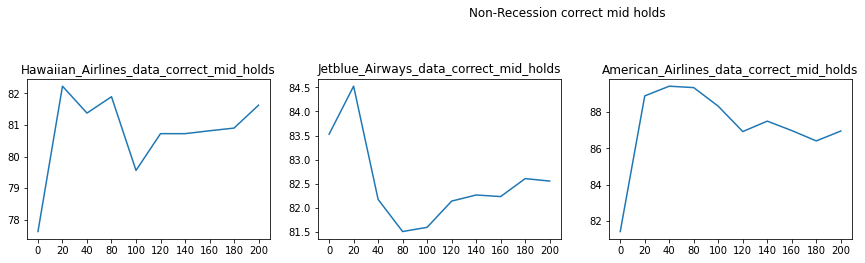

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

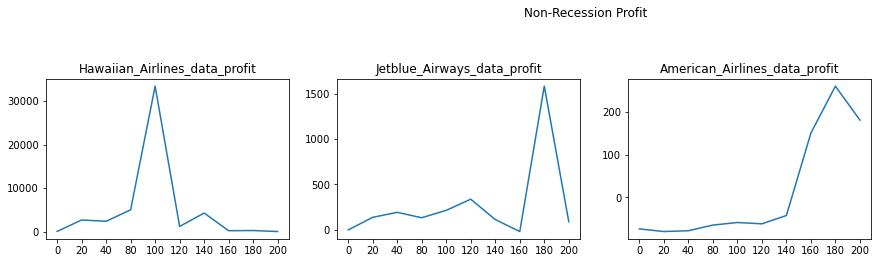

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

In [51]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


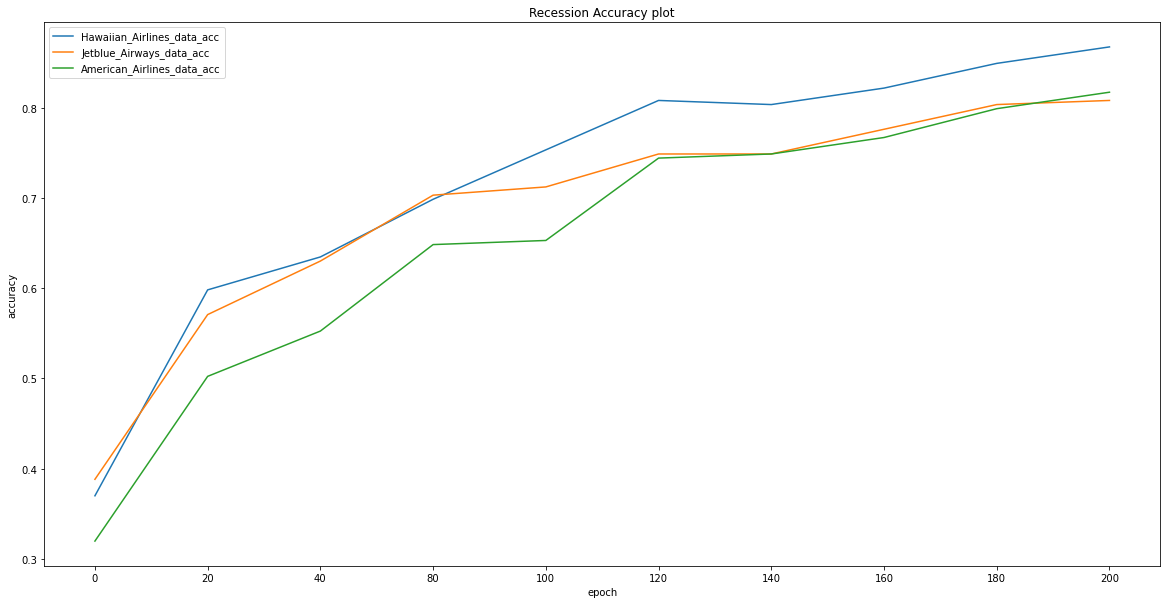

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

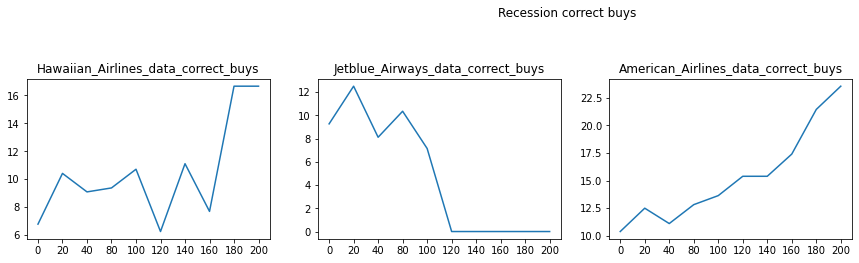

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

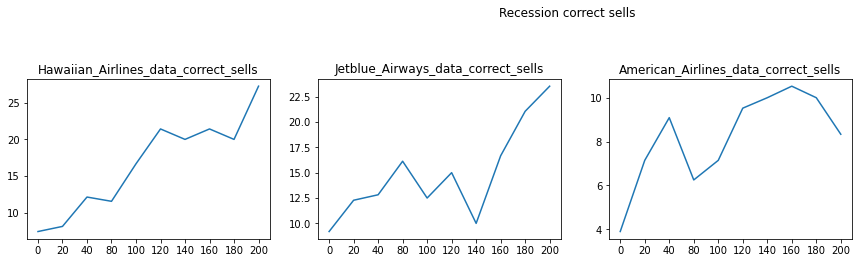

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

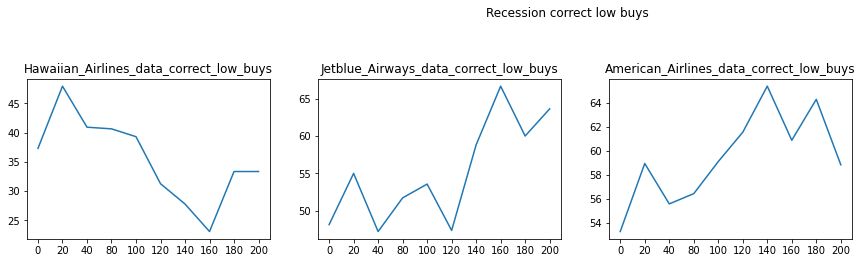

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

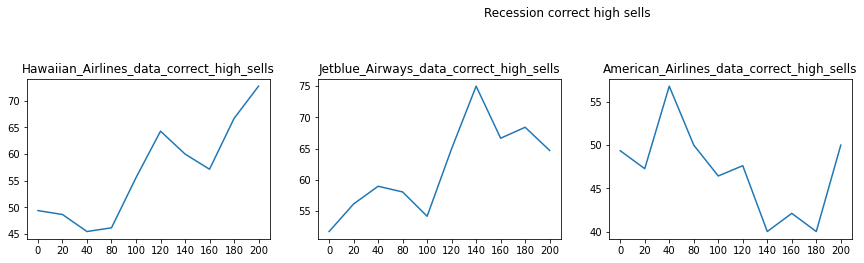

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

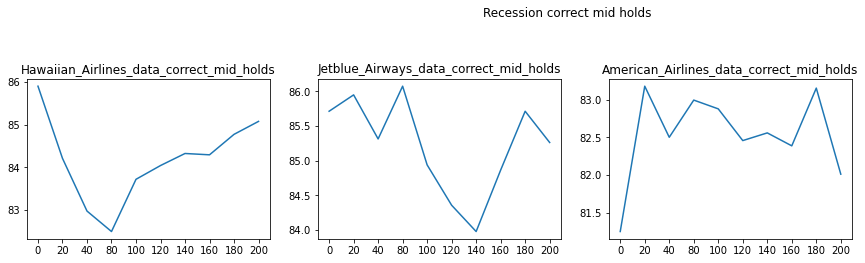

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

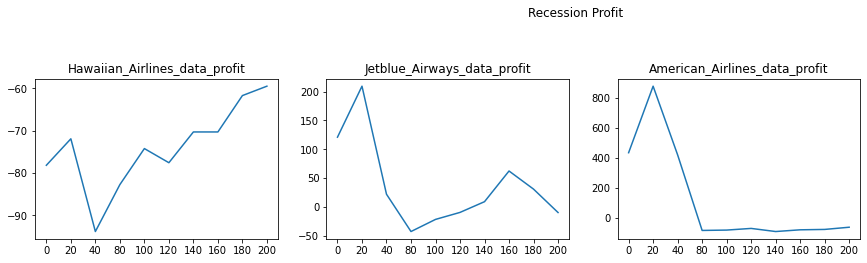

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

## Train American Airlines Stock Data

In [59]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2005-10-17    22.270000  21.619546 -18.717939  12563700.0     2.0
2005-10-18    22.080000  21.690385 -24.210533  12099700.0     2.0
2005-10-19    21.490000  21.659557 -52.068980  10284200.0     2.0
2005-10-20    21.379999  21.616548 -57.446844   8818200.0     1.0
2005-10-21    21.020000  21.524771 -92.093018   8177300.0     2.0


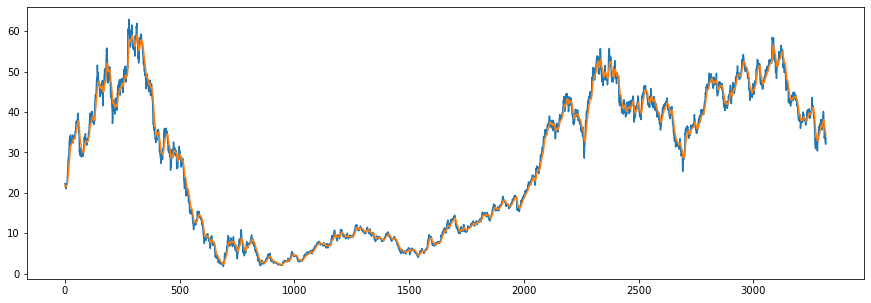

(3303, 15, 4)

In [60]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/AAL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [61]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [62]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [63]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [65]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['HA','JBLU','AAL']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'AmericanairModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'AmericanairModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.863095238095238, 1: 7.793510324483776, 2: 0.3643635360639912}



RUNNING EPOCHS 0 - 20



Epoch 1/20
21/21 [==============================] - 3s 132ms/step - loss: 0.3169 - accuracy: 0.5193 - mse: 0.4126 - weighted_accuracy: 0.2935 - weighted_mse: 0.5046 - val_loss: 0.3013 - val_accuracy: 0.0469 - val_mse: 0.3479 - val_weighted_accuracy: 0.0469 - val_weighted_mse: 0.3479
Epoch 2/20
21/21 [==============================] - 0s 10ms/step - loss: 0.2304 - accuracy: 0.4489 - mse: 0.6233 - weighted_accuracy: 0.4093 - weighted_mse: 0.6242 - val_loss: 0.2962 - val_accuracy: 0.0424 - val_mse: 0.3653 - val_weighted_accuracy: 0.0424 - val_weighted_mse: 0.3653
Epoch 3/20
21/21 [==============================] - 0s 9ms/step - loss: 0.2009 - accuracy: 0.3414 - mse: 0.8478 - weighted_accuracy: 0.4549 - weighted_mse: 0.8118 - val_loss: 0.2895 - val_accuracy: 0.0424 - val_mse: 0.3907 - val_weighted_accuracy: 0.0424 - val_weighted_mse: 0.3907
Epoch 4/20
21/21 [==============================] - 0s 

7/7 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.1872 - mse: 1.2557 - weighted_accuracy: 0.1872 - weighted_mse: 1.2557
Test loss: 0.20590057969093323
Test accuracy: 0.18721461296081543


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 7
actual predicted sells: 2
actual sells but predicted hold: 1
actual holds but predicted buy: 165
actual holds but predicted sell: 4
actual predicted holds: 30
Percentage buys correct: 4.972375690607735%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 39.44444444444444%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previous

7/7 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.3028 - mse: 1.1791 - weighted_accuracy: 0.3028 - weighted_mse: 1.1791
Test loss: 0.19711463153362274
Test accuracy: 0.302752286195755


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 133
actual holds but predicted sell: 15
actual predicted holds: 55
Percentage buys correct: 4.929577464788732%
Percentage sells correct: 21.05263157894737%
Percentage holds correct: 96.49122807017544%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 35.46099290780142%
Percentage high sells correct: 63.1578947368421%
Percentage mid holds correct: 89.47368421052632%


Capital: 100
Share price: $0.9193905659452468
Shares owned at the moment: 108
Cash capital at the moment: $0.4327598798276


Price increa

Epoch 7/20
21/21 [==============================] - 0s 8ms/step - loss: 0.1357 - accuracy: 0.4640 - mse: 1.5419 - weighted_accuracy: 0.7171 - weighted_mse: 1.4444 - val_loss: 0.1845 - val_accuracy: 0.3585 - val_mse: 1.3627 - val_weighted_accuracy: 0.3585 - val_weighted_mse: 1.3627
Epoch 8/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1345 - accuracy: 0.3948 - mse: 1.6088 - weighted_accuracy: 0.7004 - weighted_mse: 1.4825 - val_loss: 0.1842 - val_accuracy: 0.3540 - val_mse: 1.3724 - val_weighted_accuracy: 0.3540 - val_weighted_mse: 1.3724
Epoch 9/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1333 - accuracy: 0.4281 - mse: 1.5929 - weighted_accuracy: 0.7238 - weighted_mse: 1.4830 - val_loss: 0.1798 - val_accuracy: 0.4130 - val_mse: 1.4092 - val_weighted_accuracy: 0.4130 - val_weighted_mse: 1.4092
Epoch 10/20
21/21 [==============================] - 0s 8ms/step - loss: 0.1325 - accuracy: 0.4413 - mse: 1.6240 - weighted_accuracy: 0.7145 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1802 - accuracy: 0.4749 - mse: 1.7319 - weighted_accuracy: 0.4749 - weighted_mse: 1.7319
Test loss: 0.18020692467689514
Test accuracy: 0.47488585114479065


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 55
actual holds but predicted sell: 48
actual predicted holds: 96
Percentage buys correct: 8.19672131147541%
Percentage sells correct: 5.769230769230769%
Percentage holds correct: 90.56603773584905%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 40.98360655737705%
Percentage high sells correct: 44.23076923076923%
Percentage mid holds correct: 82.85714285714286%


Capital: 100
Share price: $0.9084870741761714
Shares owned at the moment: 109
Cash capital at the moment: $0.702589914313009


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.1770 - accuracy: 0.4429 - mse: 1.7148 - weighted_accuracy: 0.4429 - weighted_mse: 1.7148
Test loss: 0.17695869505405426
Test accuracy: 0.4429223835468292


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 4
actual holds but predicted buy: 48
actual holds but predicted sell: 66
actual predicted holds: 83
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 91.20879120879121%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 60.810810810810814%
Percentage mid holds correct: 84.44444444444444%


Capital: 100
Share price: $0.7848299580775777
Shares owned at the moment: 127
Cash capital at the moment: $0.052493461289031984


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.5023 - mse: 1.7330 - weighted_accuracy: 0.5023 - weighted_mse: 1.7330
Test loss: 0.180883526802063
Test accuracy: 0.5022830963134766


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 43
actual holds but predicted sell: 53
actual predicted holds: 102
Percentage buys correct: 8.51063829787234%
Percentage sells correct: 7.017543859649122%
Percentage holds correct: 88.69565217391305%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 51.06382978723404%
Percentage high sells correct: 54.3859649122807%
Percentage mid holds correct: 78.0701754385965%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price increa

Epoch 10/20
21/21 [==============================] - 0s 8ms/step - loss: 0.1131 - accuracy: 0.5666 - mse: 1.9560 - weighted_accuracy: 0.7941 - weighted_mse: 1.8842 - val_loss: 0.1680 - val_accuracy: 0.5446 - val_mse: 1.9620 - val_weighted_accuracy: 0.5446 - val_weighted_mse: 1.9620
Epoch 11/20
21/21 [==============================] - 0s 8ms/step - loss: 0.1121 - accuracy: 0.5674 - mse: 1.9769 - weighted_accuracy: 0.8028 - weighted_mse: 1.9040 - val_loss: 0.1756 - val_accuracy: 0.5083 - val_mse: 1.9939 - val_weighted_accuracy: 0.5083 - val_weighted_mse: 1.9939
Epoch 12/20
21/21 [==============================] - 0s 8ms/step - loss: 0.1089 - accuracy: 0.5700 - mse: 1.9842 - weighted_accuracy: 0.8151 - weighted_mse: 1.9055 - val_loss: 0.1717 - val_accuracy: 0.5477 - val_mse: 2.0196 - val_weighted_accuracy: 0.5477 - val_weighted_mse: 2.0196
Epoch 13/20
21/21 [==============================] - 0s 8ms/step - loss: 0.1105 - accuracy: 0.5844 - mse: 2.0086 - weighted_accuracy: 0.8006 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1610 - accuracy: 0.6347 - mse: 2.1200 - weighted_accuracy: 0.6347 - weighted_mse: 2.1200
Test loss: 0.16096818447113037
Test accuracy: 0.6347032189369202


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 28
actual holds but predicted sell: 40
actual predicted holds: 131
Percentage buys correct: 12.5%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 91.60839160839161%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 43.75%
Percentage high sells correct: 43.18181818181818%
Percentage mid holds correct: 83.80281690140845%


Capital: 100
Share price: $0.9084870741761714
Shares owned at the moment: 109
Cash capital at the moment: $0.702589914313009


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 0.1615 - accuracy: 0.5525 - mse: 2.0885 - weighted_accuracy: 0.5525 - weighted_mse: 2.0885
Test loss: 0.16149255633354187
Test accuracy: 0.5525113940238953


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 28
actual holds but predicted sell: 58
actual predicted holds: 111
Percentage buys correct: 12.5%
Percentage sells correct: 9.23076923076923%
Percentage holds correct: 90.98360655737704%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 56.25%
Percentage high sells correct: 58.46153846153846%
Percentage mid holds correct: 85.12396694214875%


Capital: 100
Share price: $0.6025170038678631
Shares owned at the moment: 165
Cash capital at the moment: $0.3113022712975493


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 0.1671 - accuracy: 0.5845 - mse: 2.1280 - weighted_accuracy: 0.5845 - weighted_mse: 2.1280
Test loss: 0.16706949472427368
Test accuracy: 0.5844748616218567


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 7
actual holds but predicted buy: 30
actual holds but predicted sell: 49
actual predicted holds: 119
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 9.25925925925926%
Percentage holds correct: 90.83969465648855%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 55.88235294117647%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 81.53846153846153%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price i

21/21 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.6484 - mse: 2.4300 - weighted_accuracy: 0.8408 - weighted_mse: 2.4105 - val_loss: 0.1741 - val_accuracy: 0.5552 - val_mse: 2.5337 - val_weighted_accuracy: 0.5552 - val_weighted_mse: 2.5337
Epoch 12/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0910 - accuracy: 0.6707 - mse: 2.4171 - weighted_accuracy: 0.8687 - weighted_mse: 2.3915 - val_loss: 0.1674 - val_accuracy: 0.5794 - val_mse: 2.5789 - val_weighted_accuracy: 0.5794 - val_weighted_mse: 2.5789
Epoch 13/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0924 - accuracy: 0.6775 - mse: 2.4530 - weighted_accuracy: 0.8515 - weighted_mse: 2.4286 - val_loss: 0.1790 - val_accuracy: 0.5598 - val_mse: 2.5239 - val_weighted_accuracy: 0.5598 - val_weighted_mse: 2.5239
Epoch 14/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0912 - accuracy: 0.6749 - mse: 2.4841 - weighted_accuracy: 0.8674 - weighted_mse: 2.4674

7/7 [==============================] - 0s 3ms/step - loss: 0.1746 - accuracy: 0.6147 - mse: 2.9452 - weighted_accuracy: 0.6147 - weighted_mse: 2.9452
Test loss: 0.17461532354354858
Test accuracy: 0.6146789193153381


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 34
actual holds but predicted sell: 36
actual predicted holds: 130
Percentage buys correct: 5.405405405405405%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 91.54929577464789%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 32.432432432432435%
Percentage high sells correct: 44.73684210526316%
Percentage mid holds correct: 82.3943661971831%


Capital: 100
Share price: $0.5625672725102102
Shares owned at the moment: 177
Cash capital at the moment: $0.15176314579845496


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.6347 - mse: 2.6627 - weighted_accuracy: 0.6347 - weighted_mse: 2.6627
Test loss: 0.1580101102590561
Test accuracy: 0.6347032189369202


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 24
actual holds but predicted sell: 40
actual predicted holds: 134
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 89.33333333333333%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 57.69230769230769%
Percentage high sells correct: 55.81395348837209%
Percentage mid holds correct: 80.53691275167785%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price i

21/21 [==============================] - 0s 9ms/step - loss: 0.0759 - accuracy: 0.7502 - mse: 3.0455 - weighted_accuracy: 0.9005 - weighted_mse: 3.0572 - val_loss: 0.1701 - val_accuracy: 0.6036 - val_mse: 3.1559 - val_weighted_accuracy: 0.6036 - val_weighted_mse: 3.1559
Epoch 15/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0742 - accuracy: 0.7385 - mse: 3.0867 - weighted_accuracy: 0.8962 - weighted_mse: 3.0999 - val_loss: 0.1570 - val_accuracy: 0.6657 - val_mse: 3.1836 - val_weighted_accuracy: 0.6657 - val_weighted_mse: 3.1836
Epoch 16/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0725 - accuracy: 0.7759 - mse: 3.1259 - weighted_accuracy: 0.9099 - weighted_mse: 3.1062 - val_loss: 0.1901 - val_accuracy: 0.5598 - val_mse: 3.2792 - val_weighted_accuracy: 0.5598 - val_weighted_mse: 3.2792
Epoch 17/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0741 - accuracy: 0.7559 - mse: 3.1565 - weighted_accuracy: 0.8912 - weighted_mse: 3.1495

7/7 [==============================] - 0s 3ms/step - loss: 0.1631 - accuracy: 0.6651 - mse: 3.6577 - weighted_accuracy: 0.6651 - weighted_mse: 3.6577
Test loss: 0.16311080753803253
Test accuracy: 0.6651375889778137


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 30
actual holds but predicted sell: 29
actual predicted holds: 141
Percentage buys correct: 6.0606060606060606%
Percentage sells correct: 6.25%
Percentage holds correct: 92.15686274509804%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 39.39393939393939%
Percentage high sells correct: 48.38709677419355%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.5625672725102102
Shares owned at the moment: 177
Cash capital at the moment: $0.15176314579845496


Price increase fro

7/7 [==============================] - 0s 5ms/step - loss: 0.1454 - accuracy: 0.6712 - mse: 3.2777 - weighted_accuracy: 0.6712 - weighted_mse: 3.2777
Test loss: 0.1454422026872635
Test accuracy: 0.6712328791618347


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 20
actual holds but predicted sell: 35
actual predicted holds: 143
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 89.375%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 79.87421383647799%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price increase from

21/21 [==============================] - 0s 16ms/step - loss: 0.0620 - accuracy: 0.8187 - mse: 3.8129 - weighted_accuracy: 0.9255 - weighted_mse: 3.7789 - val_loss: 0.1622 - val_accuracy: 0.6732 - val_mse: 3.7589 - val_weighted_accuracy: 0.6732 - val_weighted_mse: 3.7589
Epoch 14/20
21/21 [==============================] - 0s 11ms/step - loss: 0.0623 - accuracy: 0.8100 - mse: 3.8253 - weighted_accuracy: 0.9223 - weighted_mse: 3.8217 - val_loss: 0.1747 - val_accuracy: 0.6536 - val_mse: 3.8677 - val_weighted_accuracy: 0.6536 - val_weighted_mse: 3.8677
Epoch 15/20
21/21 [==============================] - 0s 10ms/step - loss: 0.0604 - accuracy: 0.8020 - mse: 3.8791 - weighted_accuracy: 0.9222 - weighted_mse: 3.8687 - val_loss: 0.1571 - val_accuracy: 0.7080 - val_mse: 4.1184 - val_weighted_accuracy: 0.7080 - val_weighted_mse: 4.1184
Epoch 16/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0587 - accuracy: 0.8289 - mse: 3.9420 - weighted_accuracy: 0.9320 - weighted_mse: 3.8

7/7 [==============================] - 0s 7ms/step - loss: 0.1699 - accuracy: 0.6835 - mse: 4.6177 - weighted_accuracy: 0.6835 - weighted_mse: 4.6177
Test loss: 0.169906884431839
Test accuracy: 0.6834862232208252


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 27
actual holds but predicted sell: 27
actual predicted holds: 146
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 3.4482758620689653%
Percentage holds correct: 91.82389937106919%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 36.666666666666664%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.38993710691824%


Capital: 100
Share price: $0.5625672725102102
Shares owned at the moment: 177
Cash capital at the moment: $0.15176314579845496


Price increase fro

7/7 [==============================] - 0s 6ms/step - loss: 0.1473 - accuracy: 0.7169 - mse: 4.1077 - weighted_accuracy: 0.7169 - weighted_mse: 4.1077
Test loss: 0.14733730256557465
Test accuracy: 0.7168949842453003


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 28
actual predicted holds: 154
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 89.53488372093024%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 52.94117647058823%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 80.11695906432749%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price

21/21 [==============================] - 0s 10ms/step - loss: 0.0470 - accuracy: 0.8694 - mse: 4.9310 - weighted_accuracy: 0.9496 - weighted_mse: 4.7511 - val_loss: 0.1817 - val_accuracy: 0.6687 - val_mse: 4.8378 - val_weighted_accuracy: 0.6687 - val_weighted_mse: 4.8378
Epoch 17/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0487 - accuracy: 0.8607 - mse: 5.0013 - weighted_accuracy: 0.9408 - weighted_mse: 4.8418 - val_loss: 0.1676 - val_accuracy: 0.7277 - val_mse: 5.4092 - val_weighted_accuracy: 0.7277 - val_weighted_mse: 5.4092
Epoch 18/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0455 - accuracy: 0.8694 - mse: 5.0181 - weighted_accuracy: 0.9524 - weighted_mse: 4.8735 - val_loss: 0.1638 - val_accuracy: 0.7474 - val_mse: 5.3400 - val_weighted_accuracy: 0.7474 - val_weighted_mse: 5.3400
Epoch 19/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0457 - accuracy: 0.8721 - mse: 5.0638 - weighted_accuracy: 0.9477 - weighted_mse: 4.943

7/7 [==============================] - 0s 5ms/step - loss: 0.1856 - accuracy: 0.7294 - mse: 5.6970 - weighted_accuracy: 0.7294 - weighted_mse: 5.6970
Test loss: 0.18561527132987976
Test accuracy: 0.7293577790260315


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 25
actual predicted holds: 156
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 3.7037037037037037%
Percentage holds correct: 92.3076923076923%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 31.818181818181817%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 82.84023668639053%


Capital: 100
Share price: $0.5625672725102102
Shares owned at the moment: 177
Cash capital at the moment: $0.15176314579845496


Pric

7/7 [==============================] - 0s 6ms/step - loss: 0.1553 - accuracy: 0.7169 - mse: 5.0536 - weighted_accuracy: 0.7169 - weighted_mse: 5.0536
Test loss: 0.15525870025157928
Test accuracy: 0.7168949842453003


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 15
actual holds but predicted sell: 29
actual predicted holds: 154
Percentage buys correct: 6.25%
Percentage sells correct: 6.451612903225806%
Percentage holds correct: 89.53488372093024%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 43.75%
Percentage high sells correct: 54.83870967741935%
Percentage mid holds correct: 80.11695906432749%


Capital: 100
Share price: $0.9185394706586716
Shares owned at the moment: 108
Cash capital at the moment: $0.5249309460778306


Price increase from previously

21/21 [==============================] - 0s 9ms/step - loss: 0.0399 - accuracy: 0.8777 - mse: 5.9773 - weighted_accuracy: 0.9555 - weighted_mse: 5.7359 - val_loss: 0.1855 - val_accuracy: 0.7352 - val_mse: 6.3197 - val_weighted_accuracy: 0.7352 - val_weighted_mse: 6.3197
Epoch 16/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0375 - accuracy: 0.9031 - mse: 6.0953 - weighted_accuracy: 0.9619 - weighted_mse: 5.7392 - val_loss: 0.1909 - val_accuracy: 0.7201 - val_mse: 6.0876 - val_weighted_accuracy: 0.7201 - val_weighted_mse: 6.0876
Epoch 17/20
21/21 [==============================] - 0s 11ms/step - loss: 0.0398 - accuracy: 0.8933 - mse: 6.2248 - weighted_accuracy: 0.9526 - weighted_mse: 5.8658 - val_loss: 0.1755 - val_accuracy: 0.7655 - val_mse: 6.8964 - val_weighted_accuracy: 0.7655 - val_weighted_mse: 6.8964
Epoch 18/20
21/21 [==============================] - 0s 14ms/step - loss: 0.0367 - accuracy: 0.9008 - mse: 6.2483 - weighted_accuracy: 0.9639 - weighted_mse: 5.91

7/7 [==============================] - 0s 5ms/step - loss: 0.2038 - accuracy: 0.7523 - mse: 6.9798 - weighted_accuracy: 0.7523 - weighted_mse: 6.9798
Test loss: 0.20379163324832916
Test accuracy: 0.752293586730957


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 18
actual holds but predicted sell: 21
actual predicted holds: 161
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 92.52873563218391%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 38.095238095238095%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.5625672725102102
Shares owned at the moment: 177
Cash capital at the moment: $0.15176314579845496


Pric

7/7 [==============================] - 0s 6ms/step - loss: 0.1647 - accuracy: 0.7397 - mse: 6.2763 - weighted_accuracy: 0.7397 - weighted_mse: 6.2763
Test loss: 0.16472429037094116
Test accuracy: 0.7397260069847107


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 11
actual holds but predicted sell: 27
actual predicted holds: 160
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 3.5714285714285716%
Percentage holds correct: 89.3854748603352%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.57142857142857%
Percentage mid holds correct: 80.33707865168539%


Capital: 100
Share price: $0.7757490106240568
Shares owned at the moment: 128
Cash capital at the moment: $0.4310629883810577


Price increase fro

21/21 [==============================] - 0s 16ms/step - loss: 0.0325 - accuracy: 0.9167 - mse: 7.6038 - weighted_accuracy: 0.9612 - weighted_mse: 6.9916 - val_loss: 0.1951 - val_accuracy: 0.7897 - val_mse: 8.4644 - val_weighted_accuracy: 0.7897 - val_weighted_mse: 8.4644
Epoch 18/20
21/21 [==============================] - 0s 15ms/step - loss: 0.0296 - accuracy: 0.9228 - mse: 7.6781 - weighted_accuracy: 0.9719 - weighted_mse: 7.0884 - val_loss: 0.1994 - val_accuracy: 0.7731 - val_mse: 7.9295 - val_weighted_accuracy: 0.7731 - val_weighted_mse: 7.9295
Epoch 19/20
21/21 [==============================] - 0s 15ms/step - loss: 0.0297 - accuracy: 0.9235 - mse: 7.7282 - weighted_accuracy: 0.9721 - weighted_mse: 7.1496 - val_loss: 0.1941 - val_accuracy: 0.7852 - val_mse: 8.4356 - val_weighted_accuracy: 0.7852 - val_weighted_mse: 8.4356
Epoch 20/20
21/21 [==============================] - 0s 14ms/step - loss: 0.0307 - accuracy: 0.9152 - mse: 7.7720 - weighted_accuracy: 0.9663 - weighted_mse: 7.

7/7 [==============================] - 0s 6ms/step - loss: 0.1831 - accuracy: 0.8037 - mse: 7.7245 - weighted_accuracy: 0.8037 - weighted_mse: 7.7245
Test loss: 0.18307968974113464
Test accuracy: 0.8036529421806335


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 5
actual holds but predicted sell: 18
actual predicted holds: 174
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 89.69072164948453%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 60.0%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 84.97409326424871%


Capital: 100
Share price: $0.1827890884602062
Shares owned at the moment: 545
Cash capital at the moment: $0.10599164285788731


Price increase from previously bought: 26.81911634091134

Epoch 1/20
21/21 [==============================] - 0s 22ms/step - loss: 0.0328 - accuracy: 0.9141 - mse: 7.8274 - weighted_accuracy: 0.9687 - weighted_mse: 7.2125 - val_loss: 0.2095 - val_accuracy: 0.7685 - val_mse: 8.9077 - val_weighted_accuracy: 0.7685 - val_weighted_mse: 8.9077
Epoch 2/20
21/21 [==============================] - 0s 15ms/step - loss: 0.0313 - accuracy: 0.9179 - mse: 7.8937 - weighted_accuracy: 0.9701 - weighted_mse: 7.3635 - val_loss: 0.2049 - val_accuracy: 0.7610 - val_mse: 8.2193 - val_weighted_accuracy: 0.7610 - val_weighted_mse: 8.2193
Epoch 3/20
21/21 [==============================] - 0s 15ms/step - loss: 0.0294 - accuracy: 0.9239 - mse: 7.9038 - weighted_accuracy: 0.9694 - weighted_mse: 7.3523 - val_loss: 0.2043 - val_accuracy: 0.7625 - val_mse: 7.9217 - val_weighted_accuracy: 0.7625 - val_weighted_mse: 7.9217
Epoch 4/20
21/21 [==============================] - 0s 15ms/step - loss: 0.0302 - accuracy: 0.9228 - mse: 8.0421 - weighted_accuracy: 0.9719 - weighted

7/7 [==============================] - 0s 7ms/step - loss: 0.2630 - accuracy: 0.7717 - mse: 10.6713 - weighted_accuracy: 0.7717 - weighted_mse: 10.6713
Test loss: 0.26297056674957275
Test accuracy: 0.7716894745826721


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 20
actual predicted holds: 167
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 90.76086956521739%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 30.76923076923077%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 84.15300546448087%


Capital: 100
Share price: $0.8962860009132746
Shares owned at the moment: 111
Cash capital at the moment: $0.23866259684774604


P

7/7 [==============================] - 0s 5ms/step - loss: 0.1550 - accuracy: 0.8165 - mse: 10.2040 - weighted_accuracy: 0.8165 - weighted_mse: 10.2040
Test loss: 0.15499982237815857
Test accuracy: 0.8165137767791748


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 14
actual holds but predicted sell: 12
actual predicted holds: 177
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 0.0%
Percentage holds correct: 92.67015706806282%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 33.333333333333336%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.84210526315789%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -16.134

In [66]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


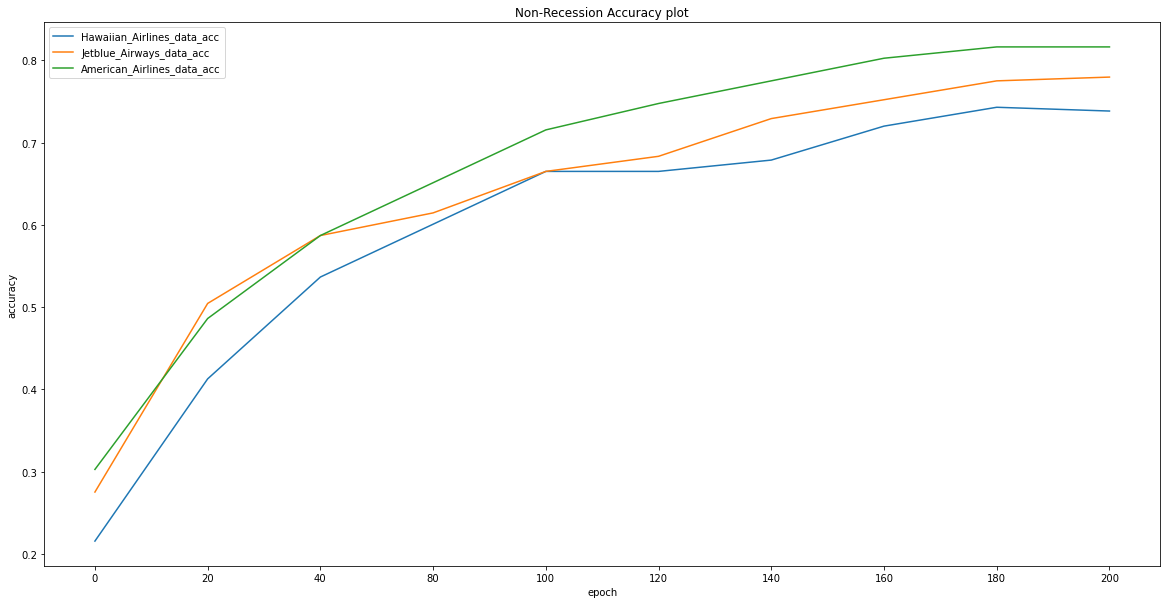

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

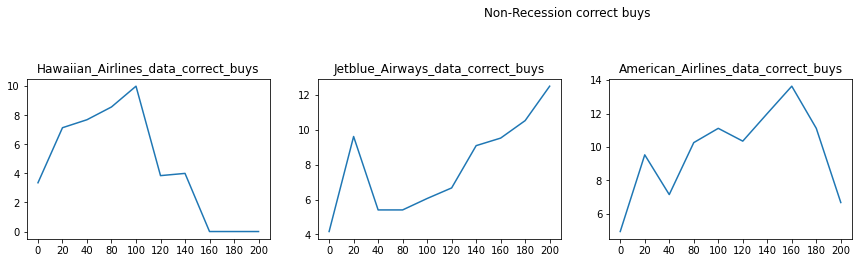

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

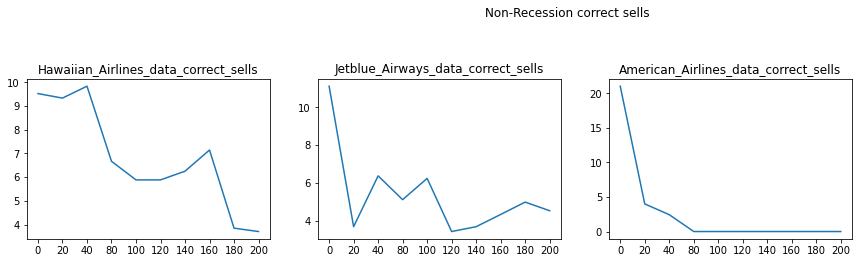

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

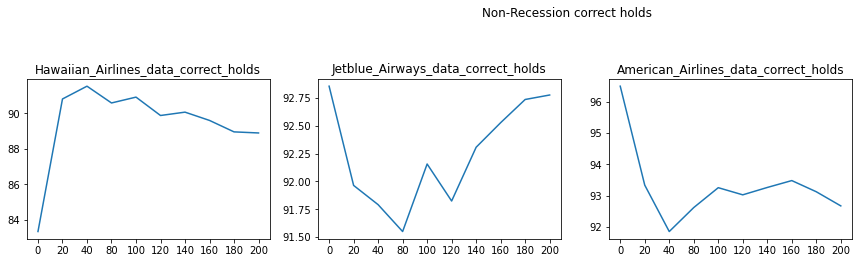

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

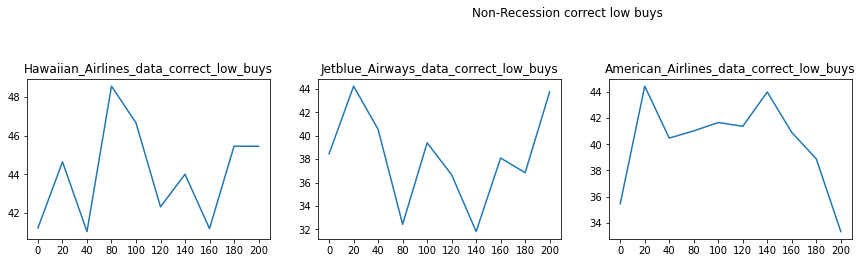

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

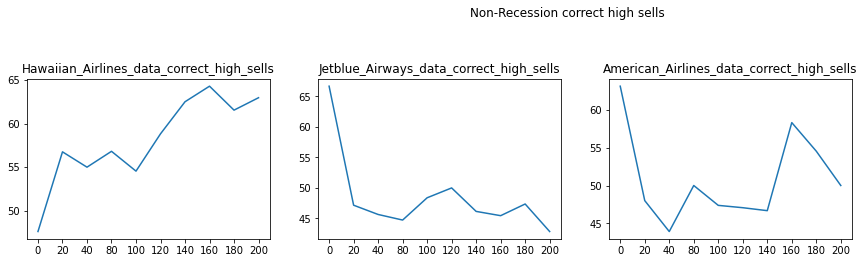

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

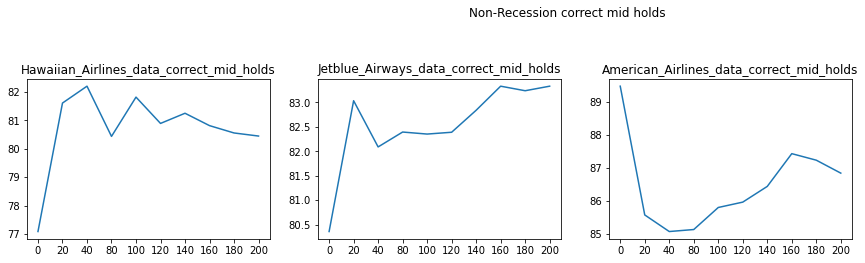

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

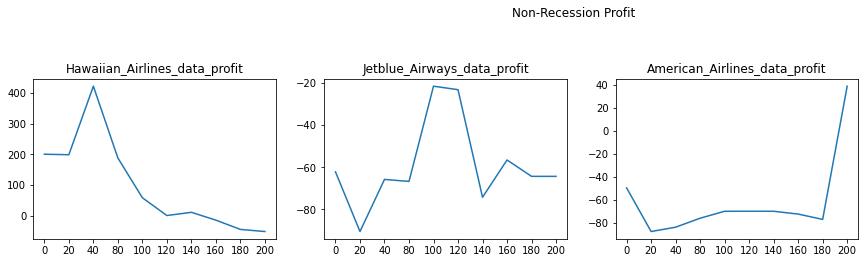

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

In [75]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


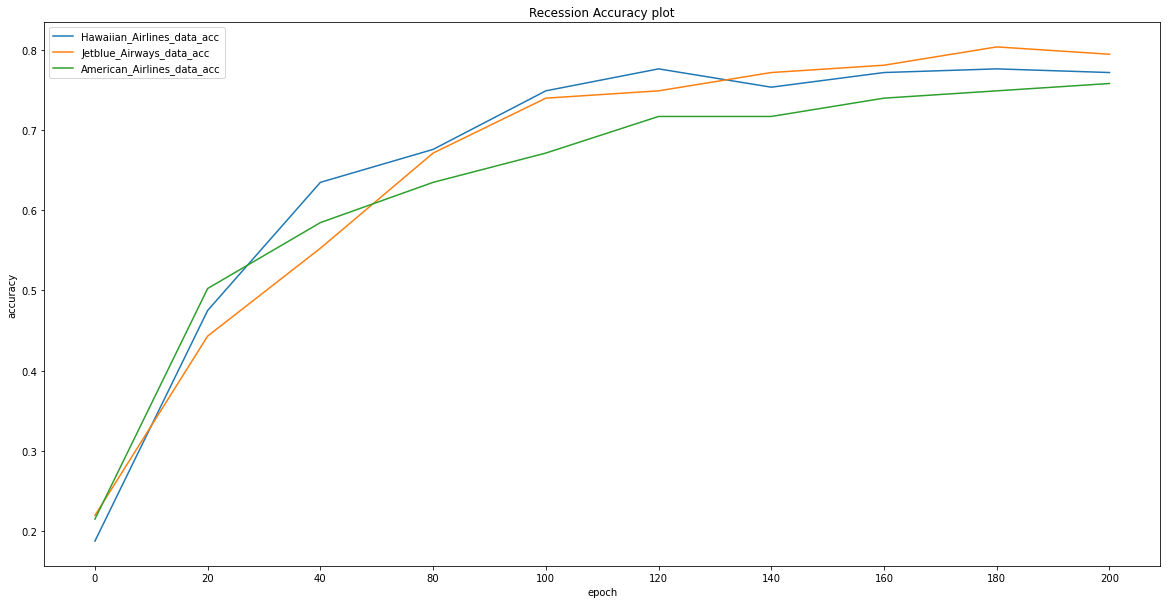

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

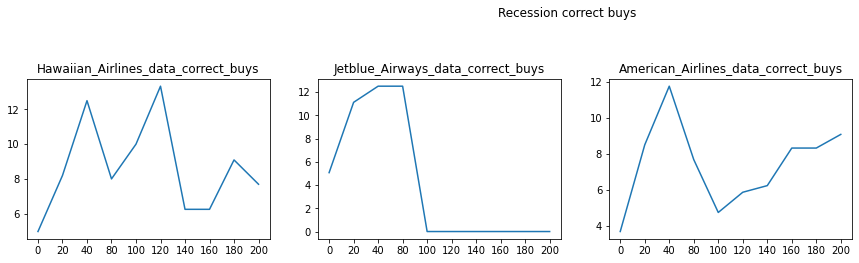

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

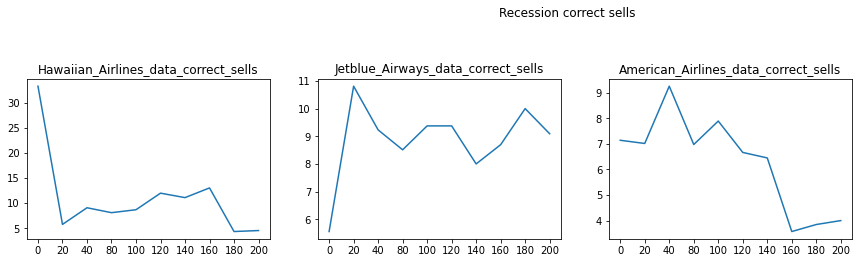

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

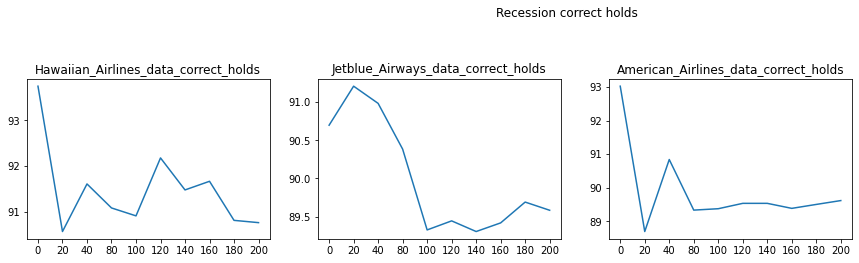

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

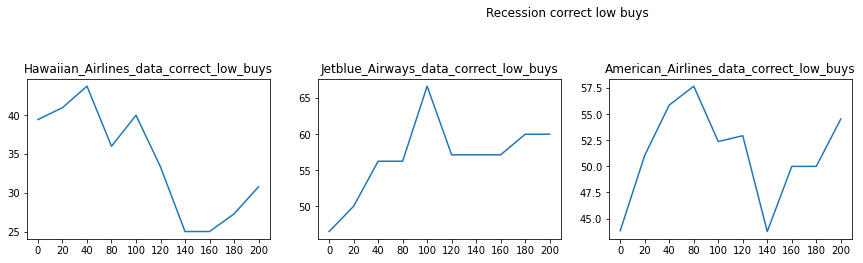

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

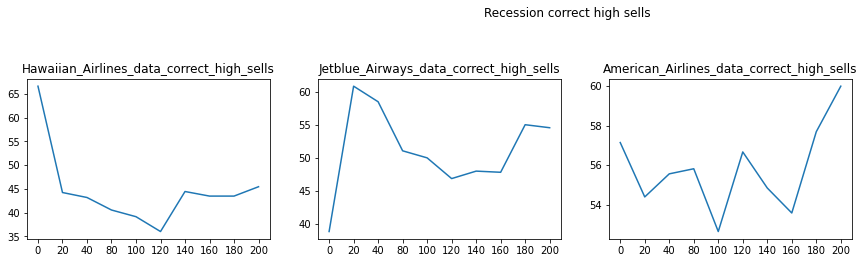

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

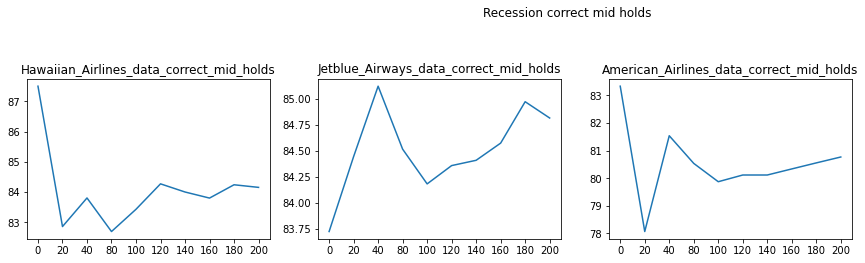

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

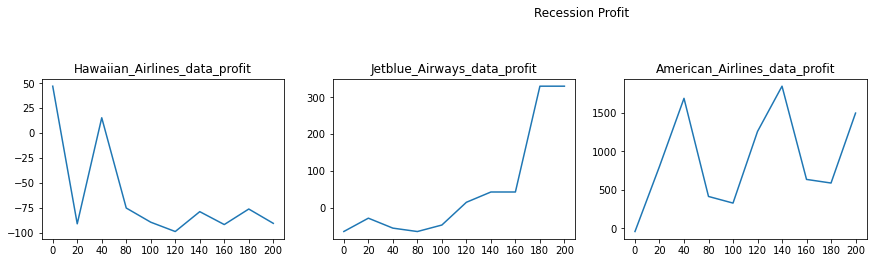

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")